In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import json
import dateutil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
import math
from collections import Counter, OrderedDict

In [2]:
datetime_parser = lambda dt: datetime.strptime(x, '%Y-%m-%d %H:%M')

In [3]:
covid_df = pd.read_csv( 'covid_19_india.csv', index_col='Sno')

In [4]:
state_testing_df = pd.read_csv( 'StatewiseTestingDetails.csv')
state_testing_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [5]:
census_df = pd.read_csv( 'population_india_census2011.csv')
census_df.head()

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


### Data Cleaning

#### I. Covid 19 Data Frame

In [6]:
covid_df = pd.read_csv( 'covid_19_india.csv', index_col='Sno')

In [7]:
covid_df.dtypes

Date                        object
Time                        object
State/UnionTerritory        object
ConfirmedIndianNational     object
ConfirmedForeignNational    object
Cured                        int64
Deaths                       int64
Confirmed                    int64
dtype: object

In [8]:
covid_df

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,,
1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
5,03/02/20,6:00 PM,Kerala,3,0,0,0,3
...,...,...,...,...,...,...,...,...
4457,24/07/20,8:00 AM,Telangana,-,-,39327,447,50826
4458,24/07/20,8:00 AM,Tripura,-,-,2072,10,3656
4459,24/07/20,8:00 AM,Uttarakhand,-,-,3399,60,5445


In [9]:
covid_df.Date = pd.to_datetime(covid_df.Date, format='%d/%m/%y')
covid_df = covid_df.rename(columns={"State/UnionTerritory": "State"})
covid_df.loc[:, 'Active'] = covid_df.loc[:, 'Confirmed'] - covid_df.loc[:, 'Deaths'] - covid_df.loc[:, 'Cured']
covid_df = covid_df[['Date', 'State', 'Cured', 'Deaths', 'Confirmed', 'Active']]
covid_df.loc[:, "Fatality Rate"] = covid_df['Deaths'] / covid_df['Cured'] * 100

In [10]:
report_date = '2020-07-23'
covid_df = covid_df[~(covid_df.State == 'Cases being reassigned to states')]
latest_df = covid_df[covid_df.Date == report_date]

In [11]:
latest_df

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
4392,2020-07-23,Andaman and Nicobar Islands,163,0,221,58,0.000000
4393,2020-07-23,Andhra Pradesh,32127,823,64713,31763,2.561708
4394,2020-07-23,Arunachal Pradesh,314,3,949,632,0.955414
4395,2020-07-23,Assam,18033,64,26772,8675,0.354905
4396,2020-07-23,Bihar,19646,217,30369,10506,1.104551
4397,2020-07-23,Chandigarh,526,13,793,254,2.471483
4398,2020-07-23,Chhattisgarh,4230,29,5968,1709,0.685579
4399,2020-07-23,Dadra and Nagar Haveli and Daman and Diu,474,2,733,257,0.421941
4400,2020-07-23,Delhi,107650,3719,126323,14954,3.454714


### Statewise Testing

In [12]:
state_testing_df.dtypes

Date             object
State            object
TotalSamples    float64
Negative         object
Positive        float64
dtype: object

In [13]:
state_testing_df.Date = pd.to_datetime(state_testing_df.Date, format='%Y-%m-%d')

In [14]:
state_testing_df = state_testing_df.set_index('Date')

In [15]:
state_testing_df.describe()

,TotalSamples,Positive
count,3.400000e+03,3386.000000
mean,1.766570e+05,10122.555818
std,2.876818e+05,29780.768372
min,5.800000e+01,0.000000
25%,1.042700e+04,130.000000
50%,4.826750e+04,1077.000000
75%,2.228228e+05,6640.750000
max,2.157869e+06,352760.000000


In [16]:
state_testing_df.isna().sum()

State              0
TotalSamples       0
Negative        1119
Positive          14
dtype: int64

In [17]:
state_testing_df[state_testing_df['Positive'].isna()]

,State,TotalSamples,Negative,Positive
Date,,,,
2020-07-23,Assam,723287.0,NaN,NaN
2020-04-01,Delhi,2621.0,NaN,NaN
2020-07-23,Gujarat,591561.0,NaN,NaN
2020-04-05,Maharashtra,16008.0,14837,NaN
2020-05-04,Sikkim,170.0,169,NaN
2020-07-15,Sikkim,13352.0,11355,NaN
2020-07-17,Uttar Pradesh,1379534.0,NaN,NaN
2020-07-21,Uttar Pradesh,1554116.0,NaN,NaN
2020-04-04,West Bengal,1042.0,NaN,NaN


In [18]:
state_testing_df['Negative'] = state_testing_df['TotalSamples'] - state_testing_df['Positive']

In [19]:
state_testing_df.isna().sum()

State            0
TotalSamples     0
Negative        14
Positive        14
dtype: int64

In [20]:
state_testing_df = state_testing_df[~(state_testing_df.Positive.isna())]

In [21]:
covid_temp = covid_df

In [22]:
covid_temp = covid_temp.set_index('Date')

In [23]:
covid_temp.head()

,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Date,,,,,,
2020-01-30,Kerala,0,0,1,1,NaN
2020-01-31,Kerala,0,0,1,1,NaN
2020-02-01,Kerala,0,0,2,2,NaN
2020-02-02,Kerala,0,0,3,3,NaN
2020-02-03,Kerala,0,0,3,3,NaN


In [24]:
merged_df = pd.merge(covid_temp, state_testing_df, how='inner', left_index=True, right_index=True, on='State')

In [25]:
state_testing_temp = state_testing_df
state_testing_temp = state_testing_temp.set_index(['State'], append=True)
covid_temp = covid_temp.set_index(['State'], append=True)

In [26]:
merged_df = pd.merge(covid_temp, state_testing_temp, left_index=True, right_index=True, how='left').fillna(0)

In [27]:
merged_df = merged_df.sort_index(level=0, ascending=False)

In [28]:
# covid_df.loc[:, "Positive Rate"] = covid_df['Deaths'] / covid_df['Cured'] * 100
merged_df.loc[merged_df.index.get_level_values(1) == 'Maharashtra']

,,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive
Date,State,,,,,,,,
2020-07-24,Maharashtra,194253,12854,347502,140395,6.617144,0.0,0.0,0.0
2020-07-23,Maharashtra,187769,12556,337607,137282,6.686940,1741992.0,1389232.0,352760.0
2020-07-22,Maharashtra,182217,12276,327031,132538,6.737022,1691546.0,1348610.0,342936.0
2020-07-21,Maharashtra,175029,12030,318695,131636,6.873147,1643981.0,1311150.0,332831.0
2020-07-20,Maharashtra,169569,11854,310455,129032,6.990665,1603802.0,1279592.0,324210.0
...,...,...,...,...,...,...,...,...,...
2020-03-13,Maharashtra,0,0,14,14,0.000000,0.0,0.0,0.0
2020-03-12,Maharashtra,0,0,11,11,0.000000,0.0,0.0,0.0
2020-03-11,Maharashtra,0,0,2,2,0.000000,0.0,0.0,0.0


## Data Analysis

### Top 10 States with Max Fatalities

In [29]:
merged_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                            
2020-07-24 West Bengal    31656    1255      51757   18846       3.964493   
           Uttarakhand     3399      60       5445    1986       1.765225   
           Uttar Pradesh  35803    1289      58104   21012       3.600257   
           Tripura         2072      10       3656    1574       0.482625   
           Telangana      39327     447      50826   11052       1.136624   

                          TotalSamples  Negative  Positive  
Date       State                                            
2020-07-24 West Bengal             0.0       0.0       0.0  
           Uttarakhand             0.0       0.0       0.0  
           Uttar Pradesh           0.0       0.0       0.0  
           Tripura                 0.0       0.0       0.0  
           Telangana               0.0       0.0       0.0

In [213]:
merged_df.to_csv('activecatch.csv')

In [30]:
latest_df = latest_df.sort_values(by='Deaths', ascending=False)
top_10_states_with_highest_fatalities = latest_df[:10]

### Top 10 States with Highest Fatality Rates

In [31]:
latest_df = latest_df.sort_values(by='Fatality Rate', ascending=False)

In [32]:
top_10_states_with_highest_fatality_rate = latest_df[:10]

In [33]:
top_10_states_with_highest_fatality_rate.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
4411,2020-07-23,Maharashtra,187769,12556,337607,137282,6.686940
4402,2020-07-23,Gujarat,37260,2224,51399,11915,5.968867
4407,2020-07-23,Karnataka,27239,1519,75833,47075,5.576563
4413,2020-07-23,Meghalaya,77,4,514,433,5.194805
4410,2020-07-23,Madhya Pradesh,16836,770,24842,7236,4.573533


### Day wise Covid-19 statistics for each State

In [34]:
merged_df.head(20)

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                              
2020-07-24 West Bengal      31656    1255      51757   18846       3.964493   
           Uttarakhand       3399      60       5445    1986       1.765225   
           Uttar Pradesh    35803    1289      58104   21012       3.600257   
           Tripura           2072      10       3656    1574       0.482625   
           Telangana        39327     447      50826   11052       1.136624   
           Tamil Nadu      136793    3232     192964   52939       2.362694   
           Sikkim             122       0        460     338       0.000000   
           Rajasthan        23815     594      33220    8811       2.494226   
           Punjab            7741     277      11739    3721       3.578349   
           Puducherry        1400      34       2420     986       2.428571   
           Odisha           14393     114      21099    6592       0.792052   
           Nagaland           530       0       1174     644       0.000000   
           Mizoram            183       0        332     149       0.000000   
           Meghalaya           78       4        534     452       5.128205   
           Manipur           1466       0       2115     649       0.000000   
           Maharashtra     194253   12854     347502  140395       6.617144   
           Madhya Pradesh   17359     780      25474    7335       4.493346   
           Ladakh            1025       2       1210     183       0.195122   
           Kerala            6594      50      16110    9466       0.758265   
           Karnataka        29310    1616      80863   49937       5.513477   

                           TotalSamples  Negative  Positive  
Date       State                                             
2020-07-24 West Bengal              0.0       0.0       0.0  
           Uttarakhand              0.0       0.0       0.0  
           Uttar Pradesh            0.0       0.0       0.0  
           Tripura                  0.0       0.0       0.0  
           Telangana                0.0       0.0       0.0  
           Tamil Nadu               0.0       0.0       0.0  
           Sikkim                   0.0       0.0       0.0  
           Rajasthan                0.0       0.0       0.0  
           Punjab                   0.0       0.0       0.0  
           Puducherry               0.0       0.0       0.0  
           Odisha                   0.0       0.0       0.0  
           Nagaland                 0.0       0.0       0.0  
           Mizoram                  0.0       0.0       0.0  
           Meghalaya                0.0       0.0       0.0  
           Manipur                  0.0       0.0       0.0  
           Maharashtra              0.0       0.0       0.0  
           Madhya Pradesh           0.0       0.0       0.0  
           Ladakh                   0.0       0.0       0.0  
           Kerala                   0.0       0.0       0.0  
           Karnataka                0.0       0.0       0.0

### State Level Aggregated DF with Census DF and Covid Counts

In [35]:
census_df = census_df.rename(columns={"State / Union Territory": "State"}).set_index('State').drop(columns='Sno')

In [36]:
aggregated_df = pd.merge(merged_df, census_df, left_index=True, right_index=True)

In [37]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  
Date       State                        
2020-07-24 West Bengal             953  
           Uttarakhand             963  
           Uttar Pradesh           912  
           Tripura                 960  
           Tamil Nadu              996

In [38]:
hosp_df = pd.read_csv('HospitalBedsIndia.csv')
hosp_df_min = hosp_df[['State/UT', 'NumPublicBeds_HMIS', 'NumRuralBeds_NHP18', 'NumUrbanBeds_NHP18']]

In [39]:
hosp_df_min = hosp_df_min.rename(columns={"State/UT":"State", "NumPublicBeds_HMIS": "Public Beds", 
                            "NumRuralBeds_NHP18": "Rural Beds", "NumUrbanBeds_NHP18": "Urban Beds"}).set_index('State')

In [40]:
aggregated_df = pd.merge(aggregated_df, hosp_df_min, left_index=True, right_index=True)

In [41]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  
Date       State                                                             
2020-07-24 West Bengal             953        51163       19684       58882  
           Uttarakhand             963         6660        3284        5228  
           Uttar Pradesh           912        58310       39104       37156  
           Tripura                 960         4895        1140        3277  
           Tamil Nadu              996        72616       40179       37353

In [42]:
fatality_df = covid_df[covid_df['Fatality Rate'].notna()]
fatality_df = fatality_df[~(fatality_df['Fatality Rate'] == np.inf)]
fatality_df.dtypes

Date             datetime64[ns]
State                    object
Cured                     int64
Deaths                    int64
Confirmed                 int64
Active                    int64
Fatality Rate           float64
dtype: object

In [43]:
fatality_df = fatality_df.set_index('Date')
fatality_rate_maha = fatality_df[fatality_df['State'] == 'Maharashtra']

In [44]:
states = ['Maharashtra', 'Delhi', 'Gujarat', 'Kerela', 'Madhya Pradesh', "Uttar Pradesh"]

In [45]:
df_temp = fatality_df[fatality_df.State.isin(states)]

In [46]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  
Date       State                                                             
2020-07-24 West Bengal             953        51163       19684       58882  
           Uttarakhand             963         6660        3284        5228  
           Uttar Pradesh           912        58310       39104       37156  
           Tripura                 960         4895        1140        3277  
           Tamil Nadu              996        72616       40179       37353

In [47]:
aggregated_df.loc[:, 'Total Beds'] = aggregated_df['Public Beds'] + aggregated_df['Rural Beds'] + aggregated_df['Urban Beds']

C:\Users\govin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [48]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == report_date]
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Confirmed > 1000]

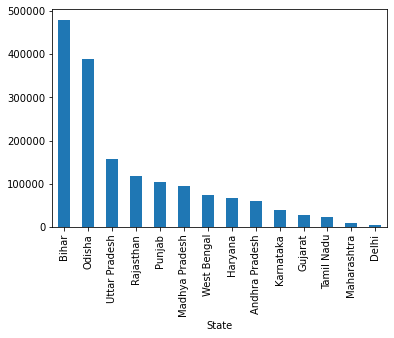

In [49]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == report_date]
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Deaths > 100]

ser_pop_deaths_ratio = (latest_df.Population / latest_df.Deaths).sort_values(ascending=False)
ser_pop_deaths_ratio.plot(kind='bar')


In [50]:
ser_pop_deaths_ratio

State
Bihar             479720.976959
Odisha            388650.166667
Uttar Pradesh     158204.545527
Rajasthan         117578.794168
Punjab            103135.085502
Madhya Pradesh     94320.531169
West Bengal        74755.212940
Haryana            68149.091398
Andhra Pradesh     60239.493317
Karnataka          40220.735352
Gujarat            27176.120504
Tamil Nadu         22947.528626
Maharashtra         8949.851306
Delhi               4514.100834
dtype: float64

### Beds to Active Patients Ratio

In [51]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == report_date, :].reset_index()
latest_df.loc[:, 'Beds/Active'] = latest_df['Total Beds'] / latest_df['Active']
df_least_beds_to_patients_ratio = latest_df.sort_values(by='Beds/Active', ascending=True).head(10)

### Finding:

- As per above statistics, if we include only covid patients, there are only 2.5 beds available for 1 covid-19 patient in Maharashtra, which is alarming, given covid-19 is yet to peak.


- Also, there are only 2 beds available for each covid-19 patient in Delhi.

### Mortality rate per 1000000

In [52]:
latest_df.loc[:, 'Mortality/1000000'] = (latest_df['Deaths'] / latest_df['Population']) * 1000000
latest_df['Population_Density_square_km'] = latest_df['Density'].str.split('/').str[0]
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,...,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
0,2020-07-23,West Bengal,29650,1221,49321,18450,4.118044,758027.0,706270.0,51757.0,...,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,51163,19684,58882,129729,7.031382,13.376994,"1,029"
1,2020-07-23,Uttarakhand,3349,57,5300,1894,1.702001,132840.0,127395.0,5445.0,...,"53,483 km2 (20,650 sq mi)",189/km2 (490/sq mi),963,6660,3284,5228,15172,8.010560,5.651234,189
2,2020-07-23,Uttar Pradesh,33500,1263,55588,20825,3.770149,1654651.0,1596547.0,58104.0,...,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912,58310,39104,37156,134570,6.461945,6.320931,828
3,2020-07-23,Tripura,2032,9,3449,1408,0.442913,127742.0,124065.0,3677.0,...,"10,486 km2 (4,049 sq mi)",350/km2 (910/sq mi),960,4895,1140,3277,9312,6.613636,2.449702,350
4,2020-07-23,Tamil Nadu,131583,3144,186492,51765,2.389366,2157869.0,1964905.0,192964.0,...,"130,058 km2 (50,216 sq mi)","555/km2 (1,440/sq mi)",996,72616,40179,37353,150148,2.900570,43.577677,555


In [53]:
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].str.replace(',', '')
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].astype(np.int)

In [54]:
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,...,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
0,2020-07-23,West Bengal,29650,1221,49321,18450,4.118044,758027.0,706270.0,51757.0,...,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,51163,19684,58882,129729,7.031382,13.376994,1029
1,2020-07-23,Uttarakhand,3349,57,5300,1894,1.702001,132840.0,127395.0,5445.0,...,"53,483 km2 (20,650 sq mi)",189/km2 (490/sq mi),963,6660,3284,5228,15172,8.010560,5.651234,189
2,2020-07-23,Uttar Pradesh,33500,1263,55588,20825,3.770149,1654651.0,1596547.0,58104.0,...,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912,58310,39104,37156,134570,6.461945,6.320931,828
3,2020-07-23,Tripura,2032,9,3449,1408,0.442913,127742.0,124065.0,3677.0,...,"10,486 km2 (4,049 sq mi)",350/km2 (910/sq mi),960,4895,1140,3277,9312,6.613636,2.449702,350
4,2020-07-23,Tamil Nadu,131583,3144,186492,51765,2.389366,2157869.0,1964905.0,192964.0,...,"130,058 km2 (50,216 sq mi)","555/km2 (1,440/sq mi)",996,72616,40179,37353,150148,2.900570,43.577677,555


In [55]:
covid_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
1,2020-01-30,Kerala,0,0,1,1,NaN
2,2020-01-31,Kerala,0,0,1,1,NaN
3,2020-02-01,Kerala,0,0,2,2,NaN
4,2020-02-02,Kerala,0,0,3,3,NaN
5,2020-02-03,Kerala,0,0,3,3,NaN


### Visual Analysis of most affected states

In [56]:
aggregated_df.index.get_level_values(1).unique()

Index(['West Bengal', 'Uttarakhand', 'Uttar Pradesh', 'Tripura', 'Tamil Nadu',
       'Sikkim', 'Rajasthan', 'Punjab', 'Puducherry', 'Odisha', 'Nagaland',
       'Mizoram', 'Meghalaya', 'Manipur', 'Maharashtra', 'Madhya Pradesh',
       'Kerala', 'Karnataka', 'Jharkhand', 'Himachal Pradesh', 'Haryana',
       'Gujarat', 'Goa', 'Delhi', 'Chhattisgarh', 'Chandigarh', 'Bihar',
       'Assam', 'Arunachal Pradesh', 'Andhra Pradesh'],
      dtype='object', name='State')

In [57]:
temp_df = aggregated_df.reset_index()
top_states_df = temp_df[temp_df['State'].isin(['Maharashtra', 'Gujarat', 'Tamil Nadu', 'Delhi', 'Madhya Pradesh'])].set_index(['Date', 'State']).sort_index(axis =0, ascending=True)[['Cured', 'Deaths', 'Confirmed', 'Active', 'Positive', 'TotalSamples', 'Negative']]

In [58]:
top_states_df_daily_counts = top_states_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].diff().fillna(top_states_df)
top_states_df_daily_counts = top_states_df_daily_counts.query('TotalSamples > 0')
top_states_df_daily_counts = top_states_df_daily_counts.query('Confirmed > 0')

In [59]:
top_states_df_daily_counts = top_states_df_daily_counts.reset_index().set_index('Date')

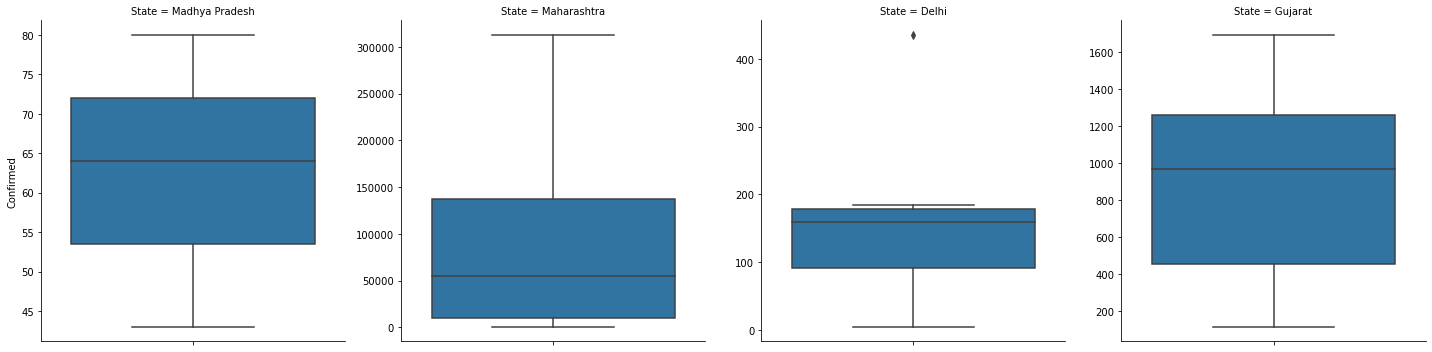

In [60]:
sns.catplot(y='Confirmed', kind='box' ,data=top_states_df_daily_counts, col='State', sharey=False)

In [61]:
top_states_df_daily_counts = top_states_df_daily_counts.reset_index().set_index(['Date', 'State'])

In [62]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Deaths > 0]
temp = temp.reset_index().set_index(['Date'])

In [63]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Confirmed > 0]
temp = temp.reset_index().set_index('Date')

In [64]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Active > 0]
temp = temp.reset_index().set_index('Date')

#### Plot to show correlation between Confirmed Cases and Deaths

In [65]:
temp = temp.set_index('State', append=True)

In [66]:
temp = temp[(temp.values > 0).all(1)]
temp = temp.reset_index().set_index('Date')

In [67]:
sorted_agg_df = aggregated_df.sort_index(level=0, ascending=True)

In [68]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-07-24 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-07-24 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

### Maharashtra Covid Analysis 

In [69]:
maha_df = aggregated_df.query('State == "Maharashtra"').reset_index().set_index('Date').sort_index(axis=0, ascending=True)
maha_df

,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,Population,Rural population,Urban population,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds
Date,,,,,,,,,,,,,,,,,,,
2020-03-09,Maharashtra,0,0,2,2,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-10,Maharashtra,0,0,5,5,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-11,Maharashtra,0,0,2,2,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-12,Maharashtra,0,0,11,11,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-13,Maharashtra,0,0,14,14,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,Maharashtra,169569,11854,310455,129032,6.990665,1603802.0,1279592.0,324210.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-07-21,Maharashtra,175029,12030,318695,131636,6.873147,1643981.0,1311150.0,332831.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-07-22,Maharashtra,182217,12276,327031,132538,6.737022,1691546.0,1348610.0,342936.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444


In [70]:
maha_df = aggregated_df.query('State == "Maharashtra"').reset_index().set_index('Date').sort_index(axis=0, ascending=True)

In [71]:
maha_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].tail(10)

,TotalSamples,Cured,Confirmed,Deaths,Active,Negative,Positive
Date,,,,,,,
2020-07-15,1413185.0,149007,267665,10695,107963,1132434.0,280751.0
2020-07-16,1450129.0,152613,275640,10928,112099,1161433.0,288696.0
2020-07-17,1487738.0,158140,284281,11194,114947,1190958.0,296780.0
2020-07-18,1526037.0,160357,292589,11452,120780,1220496.0,305541.0
2020-07-19,1568229.0,165663,300937,11596,123678,1252842.0,315387.0
2020-07-20,1603802.0,169569,310455,11854,129032,1279592.0,324210.0
2020-07-21,1643981.0,175029,318695,12030,131636,1311150.0,332831.0
2020-07-22,1691546.0,182217,327031,12276,132538,1348610.0,342936.0
2020-07-23,1741992.0,187769,337607,12556,137282,1389232.0,352760.0


In [72]:
maha_df_daily_counts = maha_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].diff()

In [73]:
df_t = maha_df_daily_counts.pct_change().dropna()

In [74]:
df_t = df_t[(df_t.values != np.inf).all(1)]

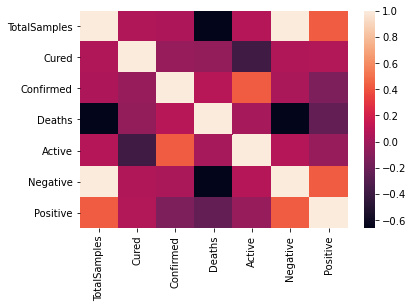

In [75]:
sns.heatmap(df_t.corr())

C:\Users\govin\anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


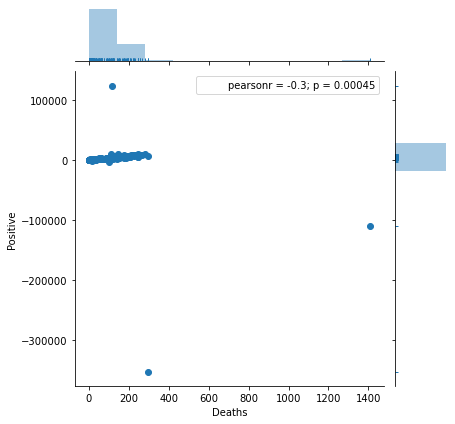

In [76]:
sns.jointplot(x='Deaths', y='Positive', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

In [77]:
maha_df_daily_counts = maha_df_daily_counts.query('TotalSamples > 0')

In [78]:
maha_df_daily_counts.head()

,TotalSamples,Cured,Confirmed,Deaths,Active,Negative,Positive
Date,,,,,,,
2020-04-06,17563.0,14.0,258.0,21.0,223.0,16695.0,868.0
2020-04-07,3314.0,0.0,120.0,3.0,117.0,3164.0,150.0
2020-04-09,20877.0,38.0,117.0,8.0,71.0,20009.0,868.0
2020-04-10,9123.0,8.0,229.0,25.0,196.0,8856.0,267.0
2020-04-11,1841.0,63.0,210.0,13.0,134.0,1215.0,626.0


In [79]:
maha_df_daily_counts = maha_df_daily_counts.query('TotalSamples < 500000')

### % Positive Cases each Day 

In [80]:
positive_cases_df = aggregated_df[aggregated_df.TotalSamples > 0]

In [81]:
aggregated_df.shape

(3774, 18)

In [82]:
positive_cases_df.shape

(2963, 18)

In [83]:
print(f"There are {aggregated_df.shape[0] - positive_cases_df.shape[0]} records where Testing Data is not available.")

There are 811 records where Testing Data is not available.


In [84]:
positive_cases_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-23 West Bengal     29650    1221      49321   18450       4.118044   
           Uttarakhand      3349      57       5300    1894       1.702001   
           Uttar Pradesh   33500    1263      55588   20825       3.770149   
           Tripura          2032       9       3449    1408       0.442913   
           Tamil Nadu     131583    3144     186492   51765       2.389366   

                          TotalSamples   Negative  Positive  Population  \
Date       State                                                          
2020-07-23 West Bengal        758027.0   706270.0   51757.0    91276115   
           Uttarakhand        132840.0   127395.0    5445.0    10086292   
           Uttar Pradesh     1654651.0  1596547.0   58104.0   199812341   
           Tripura            127742.0   124065.0    3677.0     3673917   
           Tamil Nadu        2157869.0  1964905.0  192964.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-23 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-23 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-07-23 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-07-23 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

In [85]:
positive_cases_df['%Positive'] = (positive_cases_df['Positive'] / positive_cases_df['TotalSamples']) * 100 

<ipython-input-85-95fcc5db5b0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cases_df['%Positive'] = (positive_cases_df['Positive'] / positive_cases_df['TotalSamples']) * 100


In [86]:
main_states = ['Maharashtra', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh', 'Bihar', 'Tamil Nadu']

In [87]:
top_states_positive_cases_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(main_states)]

In [88]:
maharashtra_positive_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(['Maharashtra'])]
delhi_positive_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(['Delhi'])]
tamil_nadu_positive_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(['Tamil Nadu'])]

In [89]:
top_states_positive_cases_df = top_states_positive_cases_df.reset_index(level=1)

In [90]:
start_lockdown1 = '2020-03-25'
end_lockdown1 = '2020-04-14'
start_lockdown2 = '2020-04-15'
end_lockdown2 = '2020-05-03'
start_lockdown3 = '2020-05-04'
end_lockdown3 = '2020-05-17'
start_lockdown4 = '2020-05-18'
end_lockdown4 = '2020-05-31'
start_lockdown5 = '2020-06-01'
end_lockdown5 = '2020-06-30'
start_lockdown6 = '2020-07-01'
end_lockdown6 = report_date

### Avg Number of Tests Conducted Per Lockdown

In [91]:
start_lockdown_minus_1 = (datetime.datetime.strptime(start_lockdown1, '%Y-%m-%d') - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
start_lockdown_minus_1

'2020-03-24'

In [92]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-07-24 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-07-24 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

In [93]:
df_samples = aggregated_df.loc[aggregated_df.index.get_level_values(0).isin([start_lockdown_minus_1, end_lockdown1, end_lockdown2, 
                                                                end_lockdown3, end_lockdown4,
                                                               end_lockdown5])][['TotalSamples', 'Confirmed', 'Active', 'Deaths', 'Cured', 'Positive']]

In [94]:
df_samples = df_samples.reset_index(level=1)

In [95]:
df_samples['%Positive'] = df_samples['Positive'] / df_samples['TotalSamples'] * 100

In [96]:
df_samples.head()

,State,TotalSamples,Confirmed,Active,Deaths,Cured,Positive,%Positive
Date,,,,,,,,
2020-06-30,West Bengal,488038.0,17907,5535,653,11719,18559.0,3.802778
2020-06-30,Uttarakhand,69024.0,2831,681,39,2111,2881.0,4.173911
2020-06-30,Uttar Pradesh,727793.0,22828,6650,672,15506,23492.0,3.227841
2020-06-30,Tripura,64478.0,1380,294,1,1085,1393.0,2.160427
2020-06-30,Tamil Nadu,1170683.0,86224,37334,1141,47749,90167.0,7.702085


In [97]:
unique_states = set(df_samples['State'])

In [98]:
df_samples[df_samples.State == 'Delhi']

,State,TotalSamples,Confirmed,Active,Deaths,Cured,Positive,%Positive
Date,,,,,,,,
2020-06-30,Delhi,531752.0,85161,26246,2680,56235,87360.0,16.428711
2020-05-31,Delhi,212784.0,18549,10058,416,8075,19844.0,9.325889
2020-05-17,Delhi,135791.0,9333,5278,129,3926,9755.0,7.183834
2020-05-03,Delhi,60246.0,4122,2802,64,1256,4549.0,7.550709
2020-04-14,Delhi,16282.0,1510,1452,28,30,1561.0,9.587274
2020-03-24,Delhi,0.0,30,23,1,6,0.0,NaN


In [99]:
d2 = df_samples[df_samples.State == 'Delhi'].set_index('State', append=True).diff().dropna()[['TotalSamples']].apply(np.abs)
d3 = df_samples[df_samples.State == 'Maharashtra'].set_index('State', append=True).diff().dropna()[['TotalSamples']].apply(np.abs)

In [100]:
pd.concat([d2, d3])

,,TotalSamples
Date,State,
2020-05-31,Delhi,318968.0
2020-05-17,Delhi,76993.0
2020-05-03,Delhi,75545.0
2020-04-14,Delhi,43964.0
2020-05-31,Maharashtra,506984.0
2020-05-17,Maharashtra,189137.0
2020-05-03,Maharashtra,114286.0
2020-04-14,Maharashtra,118683.0


In [101]:
df_samples_final = pd.DataFrame()

for state in main_states:
    d = df_samples[df_samples.State == state].set_index('State', append=True).diff().dropna()[['TotalSamples', 'Confirmed', 'Active', 'Deaths', 'Cured', '%Positive']].apply(np.abs)
    df_samples_final = pd.concat([df_samples_final, d])


In [102]:
dft = df_samples_final.reset_index(level=1)
dft.index = dft.index.astype(str)

In [103]:
date_to_lockdown_number_map = {"2020-05-31": "Lockdown5", "2020-05-17": "Lockdown4", "2020-05-03": "Lockdown3", "2020-04-14": "Lockdown2", "2020-03-24": "Lockdown1"}

In [104]:
list_lockdown_number = list(dft.index.map(lambda val: date_to_lockdown_number_map[str(val)]))

In [105]:
df_samples_final.loc[:, 'Lockdown_Number'] = list_lockdown_number

In [106]:
df_samples_final = df_samples_final.reset_index(level=1)
df_samples_final = df_samples_final.sort_values(by='Lockdown_Number')

### The two plots below explain the reason behind recent surge in number of cases  

In [107]:
df_tmp = top_states_positive_cases_df.reset_index()

### The plots below illustrates how % positive cases are surging with increase Tests being conducted.

### Analyzing Each Lockdown 

In [108]:
lockdown1_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown1) & (aggregated_df.index.get_level_values(0) <= end_lockdown1)]
lockdown2_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown2) & (aggregated_df.index.get_level_values(0) <= end_lockdown2)]
lockdown3_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown3) & (aggregated_df.index.get_level_values(0) <= end_lockdown3)]
lockdown4_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown4) & (aggregated_df.index.get_level_values(0) <= end_lockdown4)]
lockdown5_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown5) & (aggregated_df.index.get_level_values(0) <= end_lockdown5)]
lockdown6_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown6) & (aggregated_df.index.get_level_values(0) <= end_lockdown6)]

In [109]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['Confirmed']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-04-14,2020-03-25,pct_increase1
2,Madhya Pradesh,730.0,14.0,5114.285714
3,Delhi,1510.0,31.0,4770.967742
7,West Bengal,190.0,9.0,2011.111111
8,Maharashtra,2337.0,128.0,1725.781250
11,Gujarat,617.0,38.0,1523.684211


In [110]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['Confirmed']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-03,2020-04-15,pct_increase2
0,Gujarat,5055.0,695.0,627.338129
2,Maharashtra,12296.0,2687.0,357.610718
4,West Bengal,922.0,213.0,332.863850
9,Madhya Pradesh,2846.0,987.0,188.348531
12,Delhi,4122.0,1561.0,164.061499


In [111]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['Confirmed']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-17,2020-05-04,pct_increase3
4,West Bengal,2576,963,167.497404
6,Maharashtra,30706,12974,136.673347
9,Delhi,9333,4549,105.165971
11,Gujarat,10988,5428,102.431835
18,Madhya Pradesh,4789,2942,62.780421


In [112]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['Confirmed']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-31,2020-05-18,pct_increase4
15,Maharashtra,65168.0,33053.0,97.162134
16,West Bengal,5130.0,2677.0,91.632424
18,Delhi,18549.0,10054.0,84.493734
22,Madhya Pradesh,7891.0,4977.0,58.549327
25,Gujarat,16343.0,11379.0,43.624220


In [113]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [114]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['Confirmed']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-06-30,2020-06-01,pct_increase5
12,Delhi,85161,19844,329.152389
18,West Bengal,17907,5501,225.522632
23,Maharashtra,169883,67655,151.101914
26,Gujarat,31938,16779,90.345074
28,Madhya Pradesh,13370,8089,65.286191


In [115]:
df6 = lockdown6_df.loc[lockdown6_df.index.get_level_values(0).isin([start_lockdown6, end_lockdown6])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df6 = df6.unstack(0)[['Confirmed']].dropna()
df6.columns = df6.columns.droplevel(0)
df6.columns= df6.columns.astype(str)
df6['pct_increase6'] = (df6[end_lockdown6] - df6[start_lockdown6]) / df6[start_lockdown6] * 100
df6 = df6.sort_values(by='pct_increase6', ascending=False)
df_temp6 = df6.reset_index()
df_temp6[df_temp6.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-07-23,2020-07-01,pct_increase6
11,West Bengal,49321,18559,165.752465
21,Maharashtra,337607,174761,93.182117
23,Madhya Pradesh,24842,13593,82.755830
28,Gujarat,51399,32557,57.873883
29,Delhi,126323,87360,44.600504


In [116]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5, df_temp6]

In [117]:
from functools import reduce

In [118]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [119]:
columns = ["State", "%Change", "Lockdown_Number"]
list_of_values = []

In [120]:
df_final[df_final.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1,2020-05-03,2020-04-15,pct_increase2,2020-05-17,2020-05-04,pct_increase3,2020-05-31,2020-05-18,pct_increase4,2020-06-30,2020-06-01,pct_increase5,2020-07-23,2020-07-01,pct_increase6
0,Tamil Nadu,1173.0,18.0,6416.666667,2757.0,1204.0,128.986711,10585,3023,250.148859,21184.0,11224.0,88.738418,86224,22333,286.083374,186492,90167,106.829550
2,Madhya Pradesh,730.0,14.0,5114.285714,2846.0,987.0,188.348531,4789,2942,62.780421,7891.0,4977.0,58.549327,13370,8089,65.286191,24842,13593,82.755830
3,Delhi,1510.0,31.0,4770.967742,4122.0,1561.0,164.061499,9333,4549,105.165971,18549.0,10054.0,84.493734,85161,19844,329.152389,126323,87360,44.600504
7,West Bengal,190.0,9.0,2011.111111,922.0,213.0,332.863850,2576,963,167.497404,5130.0,2677.0,91.632424,17907,5501,225.522632,49321,18559,165.752465
8,Maharashtra,2337.0,128.0,1725.781250,12296.0,2687.0,357.610718,30706,12974,136.673347,65168.0,33053.0,97.162134,169883,67655,151.101914,337607,174761,93.182117
9,Uttar Pradesh,657.0,37.0,1675.675676,2626.0,735.0,257.278912,4258,2742,55.288111,7445.0,4259.0,74.806293,22828,7823,191.806212,55588,23492,136.625234
10,Bihar,66.0,4.0,1550.000000,482.0,70.0,588.571429,1179,517,128.046422,3636.0,1262.0,188.114105,9640,3815,152.686763,30369,10043,202.389724


#### Preparing Data for Visualizing Per Lockdown Analysis 

In [121]:
list_of_values = []
for index, values in df_final[df_final.State.isin(main_states)].iterrows():
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []

    l1.append(values['State'])
    l1.append(values['pct_increase1'])
    l1.append("Lockdown1")
    
    l2.append(values['State'])
    l2.append(values['pct_increase2'])
    l2.append("Lockdown2")
    
    l3.append(values['State'])
    l3.append(values['pct_increase3'])
    l3.append("Lockdown3")
    
    l4.append(values['State'])
    l4.append(values['pct_increase4'])
    l4.append("Lockdown4")
    
    l5.append(values['State'])
    l5.append(values['pct_increase5'])
    l5.append("Lockdown5")
    
    l6.append(values['State'])
    l6.append(values['pct_increase6'])
    l6.append("Lockdown6")
    
    list_of_values.append(l1)
    list_of_values.append(l2)
    list_of_values.append(l3)
    list_of_values.append(l4)
    list_of_values.append(l5)
    list_of_values.append(l6)

In [122]:
df_lockdown_analysis = pd.DataFrame(list_of_values, columns=columns)

In [123]:
df_pct_inc = df_final[df_final.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat', 'Tamil Nadu'])][['State', 'pct_increase1', 'pct_increase2', 'pct_increase3', 'pct_increase4', 'pct_increase5']]

In [124]:
df_pct_inc['avg_pct_inc'] = (df_pct_inc['pct_increase1'] + df_pct_inc['pct_increase2'] 
                            + df_pct_inc['pct_increase3'] + df_pct_inc['pct_increase4'] + df_pct_inc['pct_increase5']) / 5

### Recovery Rate for State per lockdown

In [125]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['Cured']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1
0,West Bengal,36.0,0.0,inf
2,Bihar,26.0,0.0,inf
8,Madhya Pradesh,51.0,0.0,inf
12,Maharashtra,229.0,1.0,2.280000e+04
13,Tamil Nadu,58.0,1.0,5.700000e+03
18,Delhi,30.0,6.0,4.000000e+02
19,Uttar Pradesh,49.0,11.0,3.454545e+02


In [126]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['Cured']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(main_states)]

Date,State,2020-05-03,2020-04-15,pct_increase2
4,Delhi,1256.0,30.0,4086.666667
6,Tamil Nadu,1341.0,81.0,1555.555556
8,Uttar Pradesh,698.0,51.0,1268.627451
9,Madhya Pradesh,798.0,64.0,1146.875000
11,Maharashtra,2000.0,259.0,672.200772
16,West Bengal,151.0,37.0,308.108108
17,Bihar,117.0,29.0,303.448276


In [127]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['Cured']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(main_states)]

Date,State,2020-05-17,2020-05-04,pct_increase3
4,West Bengal,872,151,477.483444
7,Bihar,453,125,262.400000
8,Maharashtra,7088,2115,235.130024
10,Uttar Pradesh,2441,758,222.031662
11,Madhya Pradesh,2315,798,190.100251
12,Delhi,3926,1362,188.252570
15,Tamil Nadu,3538,1379,156.562727


In [128]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['Cured']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(main_states)]

Date,State,2020-05-31,2020-05-18,pct_increase4
5,Maharashtra,28081.0,7688.0,265.257544
6,Bihar,1618.0,475.0,240.631579
7,Tamil Nadu,12000.0,4172.0,187.631831
10,West Bengal,1970.0,959.0,105.422315
16,Madhya Pradesh,4444.0,2403.0,84.935497
17,Uttar Pradesh,4410.0,2441.0,80.663662
18,Delhi,8075.0,4485.0,80.044593


In [129]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [130]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['Cured']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(main_states)]

Date,State,2020-06-30,2020-06-01,pct_increase5
12,Delhi,56235,8478,563.305025
15,West Bengal,11719,2157,443.300881
18,Bihar,7390,1710,332.163743
19,Tamil Nadu,47749,12757,274.296465
22,Uttar Pradesh,15506,4709,229.284349
23,Maharashtra,88960,29329,203.317536
27,Madhya Pradesh,10199,4842,110.636101


In [131]:
df6 = lockdown6_df.loc[lockdown6_df.index.get_level_values(0).isin([start_lockdown6, end_lockdown6])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df6 = df6.unstack(0)[['Cured']].dropna()
df6.columns = df6.columns.droplevel(0)
df6.columns= df6.columns.astype(str)
df6['pct_increase6'] = (df6[end_lockdown6] - df6[start_lockdown6]) / df6[start_lockdown6] * 100
df6 = df6.sort_values(by='pct_increase6', ascending=False)
df_temp6 = df6.reset_index()
df_temp6[df_temp6.State.isin(main_states)]

Date,State,2020-07-23,2020-07-01,pct_increase6
9,Tamil Nadu,131583,50074,162.777090
11,Bihar,19646,7687,155.574346
12,West Bengal,29650,12130,144.435284
15,Uttar Pradesh,33500,16084,108.281522
16,Maharashtra,187769,90911,106.541563
21,Delhi,107650,58348,84.496469
24,Madhya Pradesh,16836,10395,61.962482


In [132]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5, df_temp6]

In [133]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [134]:
columns = ["State", "%Change", "Lockdown_Number"]
main_states = ['Maharashtra', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh', 'Bihar', 'Tamil Nadu']
list_of_values = []

In [135]:
df_final[df_final.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1,2020-05-03,2020-04-15,pct_increase2,2020-05-17,2020-05-04,pct_increase3,2020-05-31,2020-05-18,pct_increase4,2020-06-30,2020-06-01,pct_increase5,2020-07-23,2020-07-01,pct_increase6
0,West Bengal,36.0,0.0,inf,151.0,37.0,308.108108,872,151,477.483444,1970.0,959.0,105.422315,11719,2157,443.300881,29650,12130,144.435284
2,Bihar,26.0,0.0,inf,117.0,29.0,303.448276,453,125,262.400000,1618.0,475.0,240.631579,7390,1710,332.163743,19646,7687,155.574346
8,Madhya Pradesh,51.0,0.0,inf,798.0,64.0,1146.875000,2315,798,190.100251,4444.0,2403.0,84.935497,10199,4842,110.636101,16836,10395,61.962482
12,Maharashtra,229.0,1.0,2.280000e+04,2000.0,259.0,672.200772,7088,2115,235.130024,28081.0,7688.0,265.257544,88960,29329,203.317536,187769,90911,106.541563
13,Tamil Nadu,58.0,1.0,5.700000e+03,1341.0,81.0,1555.555556,3538,1379,156.562727,12000.0,4172.0,187.631831,47749,12757,274.296465,131583,50074,162.777090
18,Delhi,30.0,6.0,4.000000e+02,1256.0,30.0,4086.666667,3926,1362,188.252570,8075.0,4485.0,80.044593,56235,8478,563.305025,107650,58348,84.496469
19,Uttar Pradesh,49.0,11.0,3.454545e+02,698.0,51.0,1268.627451,2441,758,222.031662,4410.0,2441.0,80.663662,15506,4709,229.284349,33500,16084,108.281522


#### Preparing Data for Visualizing Per Lockdown Analysis 

In [136]:
list_of_values = []
for index, values in df_final[df_final.State.isin(main_states)].iterrows():
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []

    l1.append(values['State'])
    l1.append(values['pct_increase1'])
    l1.append("Lockdown1")
    
    l2.append(values['State'])
    l2.append(values['pct_increase2'])
    l2.append("Lockdown2")
    
    l3.append(values['State'])
    l3.append(values['pct_increase3'])
    l3.append("Lockdown3")
    
    l4.append(values['State'])
    l4.append(values['pct_increase4'])
    l4.append("Lockdown4")
    
    l5.append(values['State'])
    l5.append(values['pct_increase5'])
    l5.append("Lockdown5")
    
    l6.append(values['State'])
    l6.append(values['pct_increase6'])
    l6.append("Lockdown6")
    
    list_of_values.append(l1)
    list_of_values.append(l2)
    list_of_values.append(l3)
    list_of_values.append(l4)
    list_of_values.append(l5)
    list_of_values.append(l6)

In [137]:
df_lockdown_analysis = pd.DataFrame(list_of_values, columns=columns)

In [138]:
df_lockdown_analysis = df_lockdown_analysis[df_lockdown_analysis['%Change'] != np.inf]

In [139]:
d_recovered = df_lockdown_analysis.sort_values(by='Lockdown_Number')

In [140]:
d_recovered = d_recovered[~(d_recovered.Lockdown_Number.isin(['Lockdown1']))]

#### Percentage Change in Recovered Cases for Main States per lockdown 

### Testing Rate per Lockdown

In [141]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['TotalSamples']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1
0,West Bengal,3081.0,0.0,inf
2,Bihar,7727.0,0.0,inf
5,Delhi,16282.0,0.0,inf
10,Madhya Pradesh,8105.0,0.0,inf
12,Maharashtra,41071.0,0.0,inf
18,Tamil Nadu,19255.0,0.0,inf
19,Uttar Pradesh,15914.0,0.0,inf


In [142]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['TotalSamples']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(main_states)]

Date,State,2020-05-03,2020-04-15,pct_increase2
6,Tamil Nadu,150107.0,21994.0,582.490679
7,West Bengal,22915.0,3470.0,560.374640
9,Madhya Pradesh,49186.0,9596.0,412.567737
13,Uttar Pradesh,95841.0,19506.0,391.341126
18,Delhi,60246.0,16605.0,262.818428
19,Maharashtra,159754.0,45142.0,253.892163
20,Bihar,26951.0,8263.0,226.164831


In [143]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['TotalSamples']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(main_states)]

Date,State,2020-05-17,2020-05-04,pct_increase3
1,West Bengal,85956.0,25116.0,242.236025
8,Delhi,135791.0,64108.0,111.815998
10,Tamil Nadu,326720.0,162970.0,100.478616
11,Madhya Pradesh,103898.0,52095.0,99.439486
16,Uttar Pradesh,172219.0,98300.0,75.197355
21,Maharashtra,274040.0,168374.0,62.756720
22,Bihar,45729.0,28345.0,61.330041


In [144]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['TotalSamples']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(main_states)]

Date,State,2020-05-31,2020-05-18,pct_increase4
6,West Bengal,203751.0,93570.0,117.752485
15,Uttar Pradesh,289892.0,176479.0,64.264303
16,Maharashtra,463177.0,282437.0,63.993032
17,Bihar,75737.0,46996.0,61.156269
19,Delhi,212784.0,139727.0,52.285528
22,Madhya Pradesh,167808.0,112168.0,49.604165
24,Tamil Nadu,491962.0,337841.0,45.619389


In [145]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [146]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['TotalSamples']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(main_states)]

Date,State,2020-06-30,2020-06-01,pct_increase5
6,Bihar,220890.0,78090.0,182.865924
9,Delhi,531752.0,217537.0,144.442095
10,Uttar Pradesh,727793.0,297903.0,144.305361
13,Tamil Nadu,1170683.0,503339.0,132.583408
15,West Bengal,488038.0,213231.0,128.877602
20,Madhya Pradesh,365467.0,172019.0,112.457345
23,Maharashtra,970161.0,472344.0,105.392892


In [147]:
df6 = lockdown6_df.loc[lockdown6_df.index.get_level_values(0).isin([start_lockdown6, end_lockdown6])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df6 = df6.unstack(0)[['TotalSamples']].dropna()
df6.columns = df6.columns.droplevel(0)
df6.columns= df6.columns.astype(str)
df6['pct_increase6'] = (df6[end_lockdown6] - df6[start_lockdown6]) / df6[start_lockdown6] * 100
df6 = df6.sort_values(by='pct_increase6', ascending=False)
df_temp6 = df6.reset_index()
df_temp6[df_temp6.State.isin(main_states)]

Date,State,2020-07-23,2020-07-01,pct_increase6
2,Uttar Pradesh,1654651.0,758915.0,118.028501
9,Bihar,419208.0,228689.0,83.309210
11,Tamil Nadu,2157869.0,1202204.0,79.492748
12,Madhya Pradesh,658869.0,372811.0,76.730032
13,Maharashtra,1741992.0,995343.0,75.014241
19,Delhi,889597.0,551708.0,61.244173
24,West Bengal,758027.0,497596.0,52.337840


In [148]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5, df_temp6]

In [149]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [150]:
columns = ["State", "%Change", "Lockdown_Number"]
main_states = ['Maharashtra', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh', 'Bihar', 'Tamil Nadu']
list_of_values = []

In [151]:
df_final[df_final.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1,2020-05-03,2020-04-15,pct_increase2,2020-05-17,2020-05-04,pct_increase3,2020-05-31,2020-05-18,pct_increase4,2020-06-30,2020-06-01,pct_increase5,2020-07-23,2020-07-01,pct_increase6
0,West Bengal,3081.0,0.0,inf,22915.0,3470.0,560.374640,85956.0,25116.0,242.236025,203751.0,93570.0,117.752485,488038.0,213231.0,128.877602,758027.0,497596.0,52.337840
2,Bihar,7727.0,0.0,inf,26951.0,8263.0,226.164831,45729.0,28345.0,61.330041,75737.0,46996.0,61.156269,220890.0,78090.0,182.865924,419208.0,228689.0,83.309210
5,Delhi,16282.0,0.0,inf,60246.0,16605.0,262.818428,135791.0,64108.0,111.815998,212784.0,139727.0,52.285528,531752.0,217537.0,144.442095,889597.0,551708.0,61.244173
10,Madhya Pradesh,8105.0,0.0,inf,49186.0,9596.0,412.567737,103898.0,52095.0,99.439486,167808.0,112168.0,49.604165,365467.0,172019.0,112.457345,658869.0,372811.0,76.730032
12,Maharashtra,41071.0,0.0,inf,159754.0,45142.0,253.892163,274040.0,168374.0,62.756720,463177.0,282437.0,63.993032,970161.0,472344.0,105.392892,1741992.0,995343.0,75.014241
18,Tamil Nadu,19255.0,0.0,inf,150107.0,21994.0,582.490679,326720.0,162970.0,100.478616,491962.0,337841.0,45.619389,1170683.0,503339.0,132.583408,2157869.0,1202204.0,79.492748
19,Uttar Pradesh,15914.0,0.0,inf,95841.0,19506.0,391.341126,172219.0,98300.0,75.197355,289892.0,176479.0,64.264303,727793.0,297903.0,144.305361,1654651.0,758915.0,118.028501


#### Preparing Data for Visualizing Per Lockdown Analysis 

In [152]:
list_of_values = []
for index, values in df_final[df_final.State.isin(main_states)].iterrows():
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []

    l1.append(values['State'])
    l1.append(values['pct_increase1'])
    l1.append("Lockdown1")
    
    l2.append(values['State'])
    l2.append(values['pct_increase2'])
    l2.append("Lockdown2")
    
    l3.append(values['State'])
    l3.append(values['pct_increase3'])
    l3.append("Lockdown3")
    
    l4.append(values['State'])
    l4.append(values['pct_increase4'])
    l4.append("Lockdown4")
    
    l5.append(values['State'])
    l5.append(values['pct_increase5'])
    l5.append("Lockdown5")
    
    l6.append(values['State'])
    l6.append(values['pct_increase6'])
    l6.append("Lockdown6")
    
    list_of_values.append(l1)
    list_of_values.append(l2)
    list_of_values.append(l3)
    list_of_values.append(l4)
    list_of_values.append(l5)
    list_of_values.append(l6)

In [153]:
df_lockdown_analysis = pd.DataFrame(list_of_values, columns=columns)

In [154]:
df_lockdown_analysis.head()

,State,%Change,Lockdown_Number
0,West Bengal,inf,Lockdown1
1,West Bengal,560.374640,Lockdown2
2,West Bengal,242.236025,Lockdown3
3,West Bengal,117.752485,Lockdown4
4,West Bengal,128.877602,Lockdown5


In [155]:
df_lockdown_analysis = df_lockdown_analysis[df_lockdown_analysis['%Change'] != np.inf]

In [156]:
d_testing = df_lockdown_analysis.sort_values(by='Lockdown_Number')

In [157]:
d_testing = d_testing[~(d_testing.Lockdown_Number.isin(['Lockdown1']))]

#### Percentage Change in Recovered Cases for Main States per lockdown 

In [158]:
df_pct_inc = df_final[df_final.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Tamil Nadu'])][['State', 'pct_increase2', 'pct_increase3', 'pct_increase4', 'pct_increase5', 'pct_increase6']]

In [159]:
df_pct_inc

Date,State,pct_increase2,pct_increase3,pct_increase4,pct_increase5,pct_increase6
0,West Bengal,560.374640,242.236025,117.752485,128.877602,52.337840
5,Delhi,262.818428,111.815998,52.285528,144.442095,61.244173
10,Madhya Pradesh,412.567737,99.439486,49.604165,112.457345,76.730032
12,Maharashtra,253.892163,62.756720,63.993032,105.392892,75.014241
18,Tamil Nadu,582.490679,100.478616,45.619389,132.583408,79.492748


In [160]:
df_pct_inc['avg_pct_inc'] = (df_pct_inc['pct_increase6'] + df_pct_inc['pct_increase2'] 
                            + df_pct_inc['pct_increase3'] + df_pct_inc['pct_increase4'] + df_pct_inc['pct_increase5'] ) / 5

### Computing Doubling Rate for each State

In [161]:
df10 = maha_df.drop_duplicates(subset='Confirmed')

In [162]:
df10

,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,Population,Rural population,Urban population,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds
Date,,,,,,,,,,,,,,,,,,,
2020-03-09,Maharashtra,0,0,2,2,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-10,Maharashtra,0,0,5,5,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-12,Maharashtra,0,0,11,11,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-13,Maharashtra,0,0,14,14,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-15,Maharashtra,0,0,32,32,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,Maharashtra,169569,11854,310455,129032,6.990665,1603802.0,1279592.0,324210.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-07-21,Maharashtra,175029,12030,318695,131636,6.873147,1643981.0,1311150.0,332831.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-07-22,Maharashtra,182217,12276,327031,132538,6.737022,1691546.0,1348610.0,342936.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444


In [163]:
def compute_doubling_rate(confirmed_series):
    return Counter(confirmed_series.apply(math.log2).apply(math.floor).values)

In [164]:
dict_doubling_rate = dict()
for state in aggregated_df.index.get_level_values(1).unique():
    state_df = aggregated_df.loc[aggregated_df.index.get_level_values(1) == state].reset_index().set_index('Date')
    state_df = state_df.drop_duplicates(subset='Confirmed')
    state_df = state_df[state_df.Confirmed > 0]
    counter = compute_doubling_rate(state_df.Confirmed)
    if len(counter) > 0:
        dict_doubling_rate[state] = OrderedDict(counter)

### Doubling Rate for Each State

In [165]:
doubling_rate_df = pd.DataFrame(dict_doubling_rate).fillna(0)
doubling_rate_df

,West Bengal,Uttarakhand,Uttar Pradesh,Tripura,Tamil Nadu,Sikkim,Rajasthan,Punjab,Puducherry,Odisha,...,Haryana,Gujarat,Goa,Delhi,Chhattisgarh,Chandigarh,Bihar,Assam,Arunachal Pradesh,Andhra Pradesh
15,10.0,0.0,14.0,0.0,16.0,0.0,1.0,0.0,0.0,0.0,...,0.0,23.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,9.0
14,17.0,0.0,20.0,0.0,14.0,0.0,27.0,0.0,0.0,6.0,...,20.0,31.0,0.0,11.0,0.0,0.0,12.0,10.0,0.0,11.0
13,19.0,0.0,16.0,0.0,13.0,0.0,28.0,10.0,0.0,14.0,...,18.0,21.0,0.0,14.0,0.0,0.0,18.0,13.0,0.0,13.0
12,12.0,7.0,17.0,0.0,6.0,0.0,17.0,22.0,0.0,18.0,...,9.0,10.0,2.0,12.0,11.0,0.0,22.0,14.0,0.0,16.0
11,16.0,29.0,18.0,12.0,8.0,0.0,17.0,28.0,4.0,15.0,...,7.0,10.0,13.0,12.0,21.0,0.0,11.0,10.0,0.0,22.0
10,7.0,16.0,10.0,28.0,16.0,0.0,9.0,20.0,11.0,12.0,...,9.0,3.0,11.0,9.0,14.0,0.0,6.0,7.0,0.0,16.0
9,10.0,4.0,5.0,9.0,7.0,0.0,6.0,1.0,5.0,7.0,...,16.0,5.0,12.0,5.0,6.0,16.0,13.0,4.0,8.0,8.0
8,6.0,5.0,7.0,4.0,3.0,7.0,5.0,6.0,7.0,5.0,...,9.0,2.0,7.0,2.0,7.0,40.0,7.0,3.0,11.0,8.0
7,6.0,3.0,3.0,16.0,1.0,8.0,2.0,9.0,6.0,9.0,...,9.0,4.0,2.0,2.0,4.0,13.0,4.0,3.0,12.0,4.0
6,7.0,11.0,5.0,2.0,2.0,15.0,3.0,3.0,5.0,10.0,...,2.0,7.0,7.0,2.0,6.0,5.0,10.0,7.0,6.0,2.0


In [253]:
d = df10[df10['Confirmed'].diff() > 0].fillna(df10)[['Confirmed']]
d

,Confirmed
Date,
2020-03-10,5
2020-03-12,11
2020-03-13,14
2020-03-15,32
2020-03-17,39
...,...
2020-07-20,310455
2020-07-21,318695
2020-07-22,327031


In [167]:
df_new = d[d['Confirmed'].diff() > 0].fillna(d)[['Confirmed']]
d2 = df_new.diff()
d2 = d2.diff()
d2 = d2.reset_index()
d2 = d2.dropna()

In [168]:
d = d.dropna()

In [169]:
d2 = d2.set_index('Date')

In [170]:
d2 = d2.dropna()

In [171]:
d2

,Confirmed
Date,
2020-03-15,15.0
2020-03-17,-11.0
2020-03-18,-4.0
2020-03-19,2.0
2020-03-20,0.0
...,...
2020-07-20,1170.0
2020-07-21,-1278.0
2020-07-22,96.0


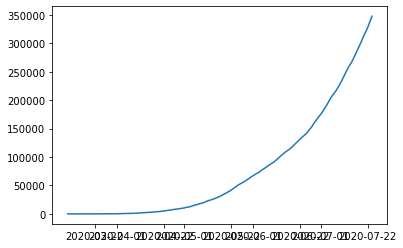

In [172]:
plt.plot(d)

In [214]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [215]:
d.head()

,Confirmed
Date,
2020-03-12,6.0
2020-03-13,3.0
2020-03-15,18.0
2020-03-17,7.0
2020-03-18,3.0


In [216]:
d.shape

(130, 1)

In [217]:
dates = [i.to_pydatetime().date() for i in d.index]
base_date = dates[0]
days=[int((i-base_date).days) for i in dates]

In [218]:
d['Days passed'] = days

In [219]:
d.index = days

In [220]:
d

,Confirmed,Days passed
0,6.0,0
1,3.0,1
3,18.0,3
5,7.0,5
6,3.0,6
...,...,...
130,9518.0,130
131,8240.0,131
132,8336.0,132
133,10576.0,133


In [221]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

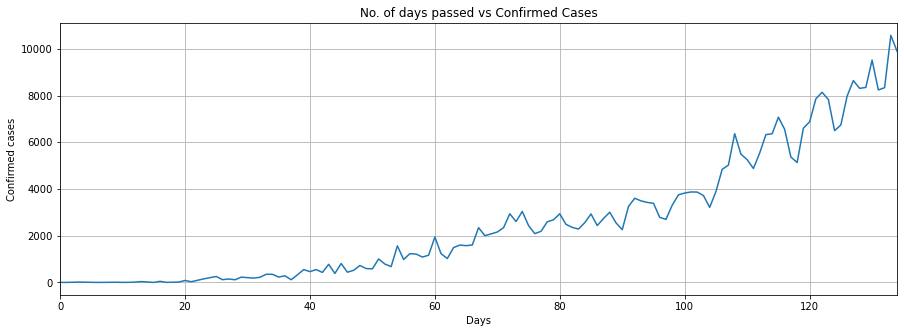

In [222]:
plt.title('No. of days passed vs Confirmed Cases')
plt.ylabel('Confirmed cases')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(d['Confirmed'])

In [223]:
all_data = d['Confirmed'].values.astype(float)

In [224]:
print(all_data)

[6.0000e+00 3.0000e+00 1.8000e+01 7.0000e+00 3.0000e+00 5.0000e+00
 5.0000e+00 1.1000e+01 4.0000e+00 7.0000e+00 1.5000e+01 3.9000e+01
 2.0000e+00 5.0000e+01 6.0000e+00 1.2000e+01 1.8000e+01 8.6000e+01
 3.3000e+01 1.5500e+02 2.5800e+02 1.2000e+02 1.5000e+02 1.1700e+02
 2.2900e+02 2.1000e+02 1.8700e+02 2.2400e+02 3.5200e+02 3.5000e+02
 2.3200e+02 2.8600e+02 1.1800e+02 3.2800e+02 5.5200e+02 4.6600e+02
 5.5200e+02 4.3100e+02 7.7800e+02 3.8700e+02 8.1100e+02 4.4000e+02
 5.2200e+02 7.2800e+02 5.9700e+02 5.8300e+02 1.0080e+03 7.9000e+02
 6.7800e+02 1.5670e+03 9.8400e+02 1.2330e+03 1.2160e+03 1.0890e+03
 1.1650e+03 1.9430e+03 1.2300e+03 1.0260e+03 1.4950e+03 1.6020e+03
 1.5760e+03 1.6060e+03 2.3470e+03 2.0050e+03 2.0780e+03 2.1610e+03
 2.3450e+03 2.9400e+03 2.6080e+03 3.0410e+03 2.4360e+03 2.0910e+03
 2.1900e+03 2.5980e+03 2.6820e+03 2.9400e+03 2.4870e+03 2.3580e+03
 2.2870e+03 2.5600e+03 2.9330e+03 2.4360e+03 2.7390e+03 3.0070e+03
 2.5530e+03 2.2590e+03 3.2540e+03 3.6070e+03 3.4930e+03 3.4270

In [225]:
test_data_size = 20

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [226]:
print(len(train_data))
print(len(test_data))

110
20


In [227]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [228]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.99874332]
 [-0.99968583]
 [-0.9949733 ]
 [-0.99842915]
 [-0.99968583]]
[[0.65095822]
 [0.53188816]
 [0.73892554]
 [0.98743324]
 [0.99874332]]


In [229]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [230]:
train_window = 15

In [231]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [232]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [233]:
train_inout_seq[:5]

[(tensor([-0.9987, -0.9997, -0.9950, -0.9984, -0.9997, -0.9991, -0.9991, -0.9972,
          -0.9994, -0.9984, -0.9959, -0.9884, -1.0000, -0.9849, -0.9987]),
  tensor([-0.9969])),
 (tensor([-0.9997, -0.9950, -0.9984, -0.9997, -0.9991, -0.9991, -0.9972, -0.9994,
          -0.9984, -0.9959, -0.9884, -1.0000, -0.9849, -0.9987, -0.9969]),
  tensor([-0.9950])),
 (tensor([-0.9950, -0.9984, -0.9997, -0.9991, -0.9991, -0.9972, -0.9994, -0.9984,
          -0.9959, -0.9884, -1.0000, -0.9849, -0.9987, -0.9969, -0.9950]),
  tensor([-0.9736])),
 (tensor([-0.9984, -0.9997, -0.9991, -0.9991, -0.9972, -0.9994, -0.9984, -0.9959,
          -0.9884, -1.0000, -0.9849, -0.9987, -0.9969, -0.9950, -0.9736]),
  tensor([-0.9903])),
 (tensor([-0.9997, -0.9991, -0.9991, -0.9972, -0.9994, -0.9984, -0.9959, -0.9884,
          -1.0000, -0.9849, -0.9987, -0.9969, -0.9950, -0.9736, -0.9903]),
  tensor([-0.9519]))]

In [234]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [235]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [236]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [237]:
epochs = 250

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.35650182
epoch:  26 loss: 0.00434567
epoch:  51 loss: 0.00866804
epoch:  76 loss: 0.00793567
epoch: 101 loss: 0.00013606
epoch: 126 loss: 0.00000046
epoch: 151 loss: 0.00100782
epoch: 176 loss: 0.00018074
epoch: 201 loss: 0.00083837
epoch: 226 loss: 0.00003053
epoch: 249 loss: 0.0015780098


In [238]:
fut_pred = 20

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]


In [239]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [240]:
test_inputs[fut_pred:]

[0.8673737049102783,
 0.3385334610939026,
 0.585623562335968,
 0.925242006778717,
 1.287940502166748,
 1.3314321041107178,
 0.6223116517066956,
 0.27730387449264526,
 0.7111557126045227,
 1.0610023736953735,
 1.2790961265563965,
 1.0034571886062622,
 0.5255501866340637,
 0.5488671064376831,
 0.9142867922782898]

In [249]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
print(actual_predictions)
print(actual_predictions.shape)

[[5899.36738652]
 [5185.87649161]
 [5289.6477477 ]
 [6204.25964832]
 [6125.90254706]
 [5945.85050273]
 [4262.55200666]
 [5049.03979892]
 [6130.04530758]
 [7284.5146184 ]
 [7422.94838738]
 [5165.81798738]
 [4067.65823251]
 [5448.60863322]
 [6562.17055547]
 [7256.36297083]
 [6379.00423133]
 [4857.82624406]
 [4932.04399979]
 [6095.17485982]]
(20, 1)


In [250]:
actual_predictions[1][0]

5185.8764916062355

In [251]:
for i in range(1,len(actual_predictions)):
    actual_predictions[i][0] += actual_predictions[i-1][0]
    
print(actual_predictions)

[[  5899.36738652]
 [ 11085.24387813]
 [ 16374.89162582]
 [ 22579.15127414]
 [ 28705.05382121]
 [ 34650.90432394]
 [ 38913.4563306 ]
 [ 43962.49612951]
 [ 50092.54143709]
 [ 57377.05605549]
 [ 64800.00444287]
 [ 69965.82243025]
 [ 74033.48066276]
 [ 79482.08929598]
 [ 86044.25985146]
 [ 93300.62282228]
 [ 99679.62705362]
 [104537.45329767]
 [109469.49729747]
 [115564.67215729]]


In [246]:
x = d.index[-20:]
print(x)
print(x.shape)

Int64Index([117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
            130, 131, 132, 133, 134, 135, 136],
           dtype='int64')
(20,)


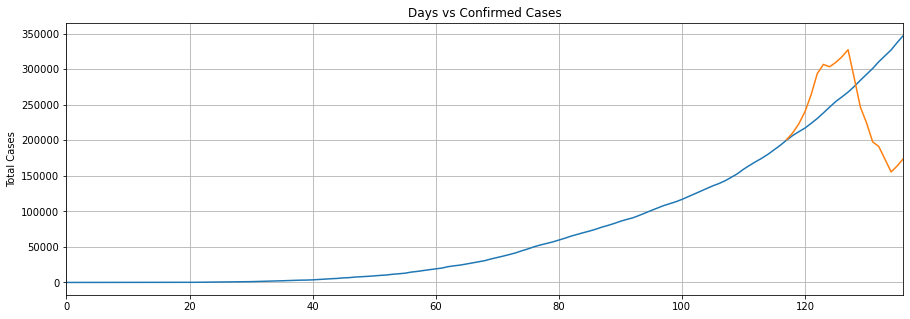

In [247]:
plt.title('Days vs Confirmed Cases')
plt.ylabel('Total Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(d['Confirmed'])
plt.plot(x,actual_predictions)
plt.show()

In [248]:
x

Int64Index([117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
            130, 131, 132, 133, 134, 135, 136],
           dtype='int64')

In [273]:
d.columns

Index(['Confirmed', 'Days passed'], dtype='object')

In [193]:
def train_with_params(hl_size,n_epochs, learn_rate):
    class LSTM(nn.Module):
        def __init__(self, input_size=1, hidden_layer_size=hl_size, output_size=1):
            super().__init__()
            self.hidden_layer_size = hidden_layer_size

            self.lstm = nn.LSTM(input_size, hidden_layer_size)

            self.linear = nn.Linear(hidden_layer_size, output_size)

            self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                                torch.zeros(1,1,self.hidden_layer_size))

        def forward(self, input_seq):
            lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
            predictions = self.linear(lstm_out.view(len(input_seq), -1))
            return predictions[-1]
    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    print(model)
    epochs = n_epochs
    print('training model')
    for i in range(epochs):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    fut_pred = 20
    print("Now testing...........")
    test_inputs = train_data_normalized[-train_window:].tolist()
    print(test_inputs)
    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())
    print("getting predictions...........")
    actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
    print("Got predictions, plotting: ")
    x = d.index[-20:]
    plt.title('Days vs Confirmed Cases')
    plt.ylabel('Total Cases')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(d['Confirmed'])
    plt.plot(x,actual_predictions)
    plt.show()

### Staring with size 200

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.58612961
epoch:  26 loss: 0.00021500
epoch:  51 loss: 0.00232954
epoch:  76 loss: 0.00005020
epoch: 101 loss: 0.00012317
epoch: 126 loss: 0.00000905
epoch: 151 loss: 0.00008089
epoch: 176 loss: 0.00001353
epoch: 201 loss: 0.00000382
epoch: 226 loss: 0.00027353
epoch: 249 loss: 0.0000061541
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
seeing predictions...........
[[ 200309.03760165]
 [ 210101.13170207]
 [ 227785.56307435]
 [ 258925.0984484 ]
 [ 247432.8671518 ]
 [ -62827.40155339]
 [-200303.90328705]
 [-183967.23226309]
 [ -17243.41764838]
 [  18324.00647074]
 [  24865.58116287]
 [  32227.00659126]
 [  39395.12742579]
 [  46070.65225154]
 [  51218.01827937]
 [  54292.34926373]
 [  56038.38264138]
 [

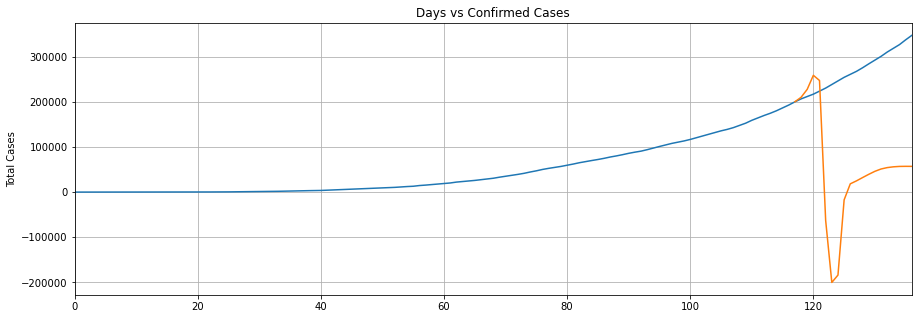

In [253]:
train_with_params(200,250,0.001)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.05304317
epoch:  26 loss: 0.00014528
epoch:  51 loss: 0.00002041
epoch:  76 loss: 0.00007971
epoch: 101 loss: 0.00002240
epoch: 126 loss: 0.00002779
epoch: 151 loss: 0.00003141
epoch: 176 loss: 0.00001819
epoch: 201 loss: 0.00000063
epoch: 226 loss: 0.00002988
epoch: 249 loss: 0.0000118970
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


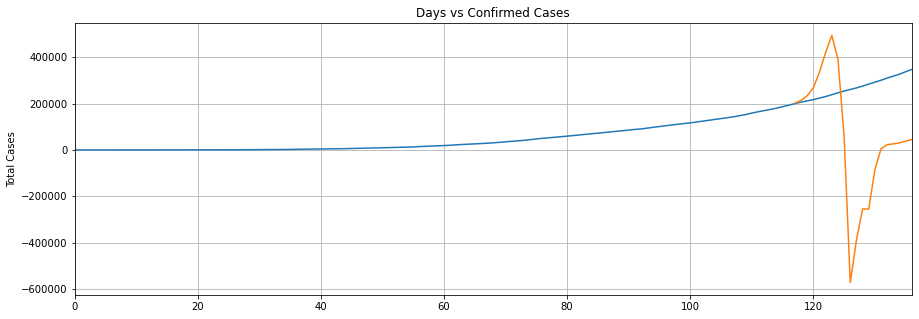

In [255]:
train_with_params(200,250,0.0005) #DO NOT TAKE

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.06091210
epoch:  26 loss: 0.00008520
epoch:  51 loss: 0.00001261
epoch:  76 loss: 0.00000003
epoch: 101 loss: 0.00031601
epoch: 126 loss: 0.00035464
epoch: 151 loss: 0.00026988
epoch: 176 loss: 0.00021879
epoch: 201 loss: 0.00018408
epoch: 226 loss: 0.00002999
epoch: 249 loss: 0.0000301245
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


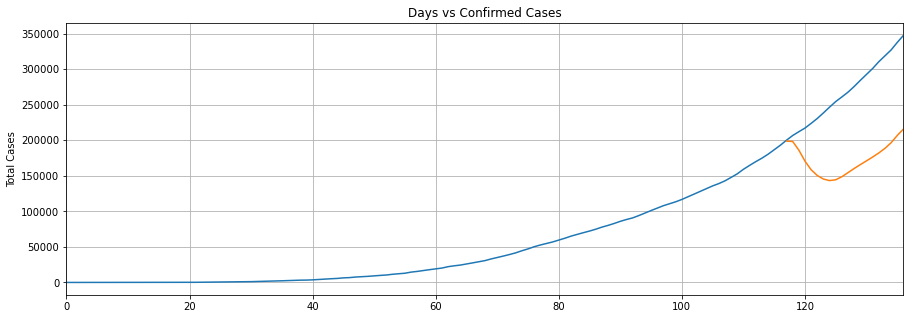

In [256]:
train_with_params(200,250,0.01)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.03042603
epoch:  26 loss: 0.24363726
epoch:  51 loss: 0.01267506
epoch:  76 loss: 0.00390140
epoch: 101 loss: 0.00289465
epoch: 126 loss: 0.00199621
epoch: 151 loss: 0.00124673
epoch: 176 loss: 0.00065914
epoch: 201 loss: 0.00025096
epoch: 226 loss: 0.00003784
epoch: 249 loss: 0.0000036671
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


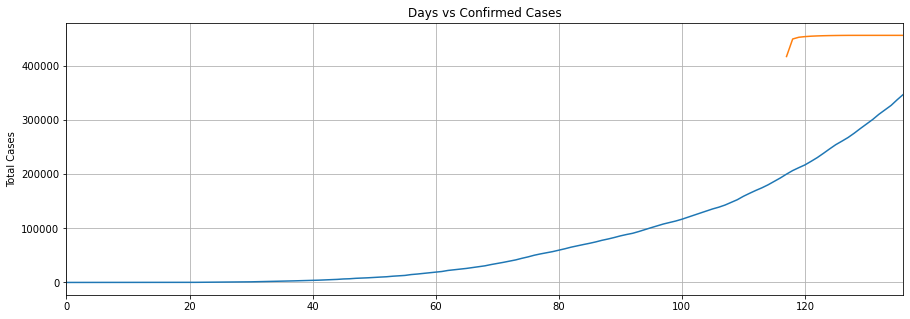

In [257]:
train_with_params(200,250,0.00001)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.98999810
epoch:  26 loss: 0.96672529
epoch:  51 loss: 0.41941950
epoch:  76 loss: 0.12197595
epoch: 101 loss: 0.02472548
epoch: 126 loss: 0.00816785
epoch: 151 loss: 0.00634988
epoch: 176 loss: 0.00550091
epoch: 201 loss: 0.00474291
epoch: 226 loss: 0.00402900
epoch: 249 loss: 0.0034081975
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


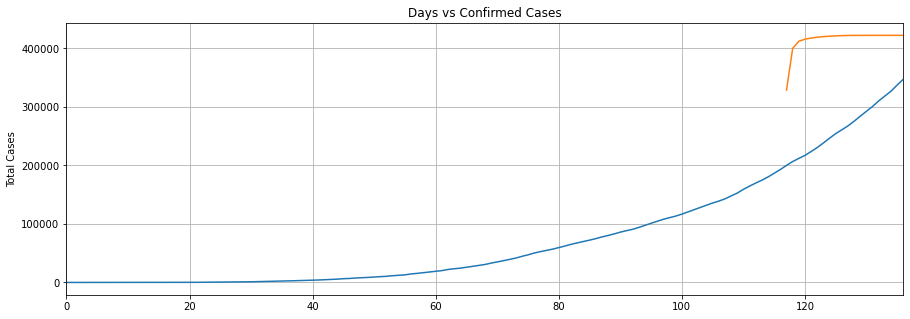

In [258]:
train_with_params(200,250,0.000005)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.87114525
epoch:  26 loss: 0.99550837
epoch:  51 loss: 0.99804747
epoch:  76 loss: 0.73252040
epoch: 101 loss: 0.51721257
epoch: 126 loss: 0.34535018
epoch: 151 loss: 0.22821733
epoch: 176 loss: 0.13498004
epoch: 201 loss: 0.06185950
epoch: 226 loss: 0.02314796
epoch: 249 loss: 0.0133211119
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


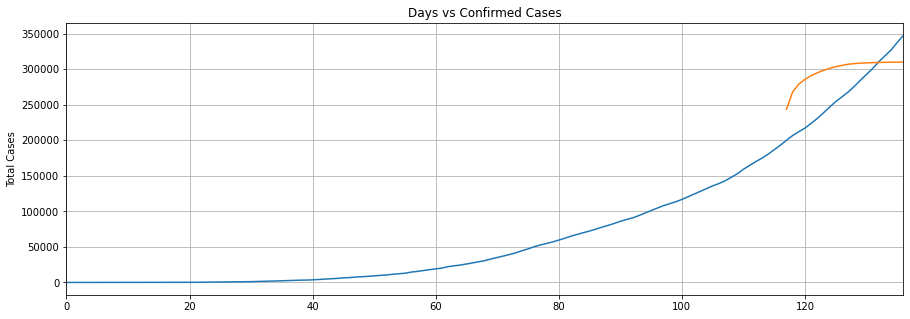

In [195]:
train_with_params(200,250,0.0000025)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.94377548
epoch:  26 loss: 1.04848409
epoch:  51 loss: 0.80334157
epoch:  76 loss: 0.48126546
epoch: 101 loss: 0.22791635
epoch: 126 loss: 0.09748165
epoch: 151 loss: 0.03256983
epoch: 176 loss: 0.01221902
epoch: 201 loss: 0.00824497
epoch: 226 loss: 0.00709703
epoch: 249 loss: 0.0065502431
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


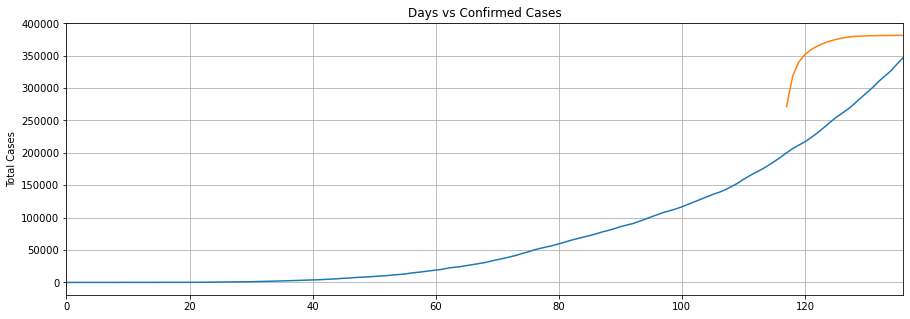

In [196]:
train_with_params(200,250,0.000003)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.05803430
epoch:  26 loss: 1.05833209
epoch:  51 loss: 1.05863130
epoch:  76 loss: 1.05893040
epoch: 101 loss: 1.05922878
epoch: 126 loss: 1.05952668
epoch: 151 loss: 1.05982435
epoch: 176 loss: 1.06012142
epoch: 201 loss: 1.06041813
epoch: 226 loss: 1.06071460
epoch: 249 loss: 1.0609868765
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


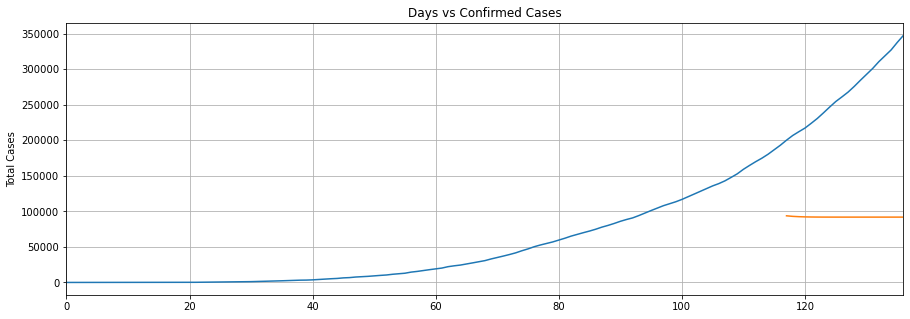

In [194]:
train_with_params(200,250,0.00000001)

### Reducing Size to 150

LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.02626840
epoch:  26 loss: 0.00013915
epoch:  51 loss: 0.00015458
epoch:  76 loss: 0.00029445
epoch: 101 loss: 0.00002497
epoch: 126 loss: 0.00006212
epoch: 151 loss: 0.00000131
epoch: 176 loss: 0.00000005
epoch: 201 loss: 0.00000146
epoch: 226 loss: 0.00000007
epoch: 249 loss: 0.0000005399
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


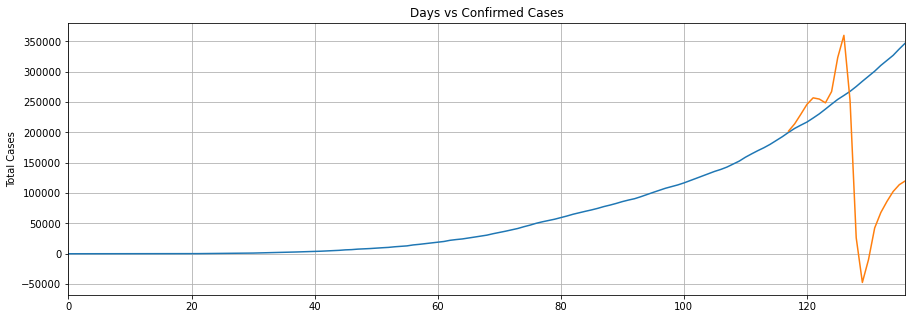

In [197]:
train_with_params(150,250,0.001) #DO NOT TAKE

LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.03870763
epoch:  26 loss: 0.00000126
epoch:  51 loss: 0.00005401
epoch:  76 loss: 0.00006915
epoch: 101 loss: 0.00000079
epoch: 126 loss: 0.00007753
epoch: 151 loss: 0.00006764
epoch: 176 loss: 0.00007495
epoch: 201 loss: 0.00008223
epoch: 226 loss: 0.00000997
epoch: 249 loss: 0.0009703586
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


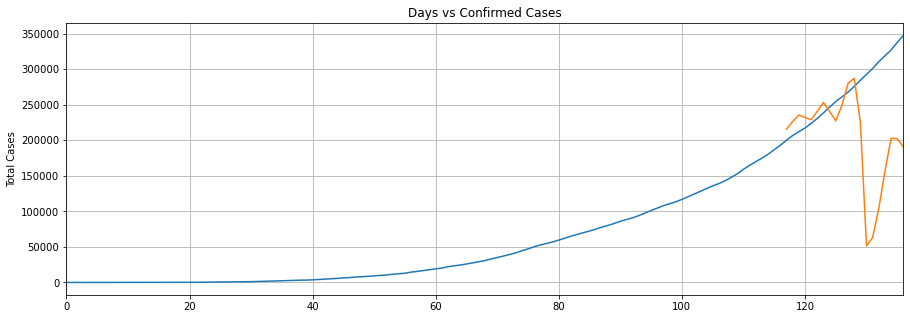

In [261]:
train_with_params(150,250,0.0005)

LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.69264930
epoch:  26 loss: 0.00000336
epoch:  51 loss: 0.00075995
epoch:  76 loss: 0.00063330
epoch: 101 loss: 0.00023897
epoch: 126 loss: 0.00002790
epoch: 151 loss: 0.00001676
epoch: 176 loss: 0.00002619
epoch: 201 loss: 0.00007716
epoch: 226 loss: 0.00003527
epoch: 249 loss: 0.0000445971
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


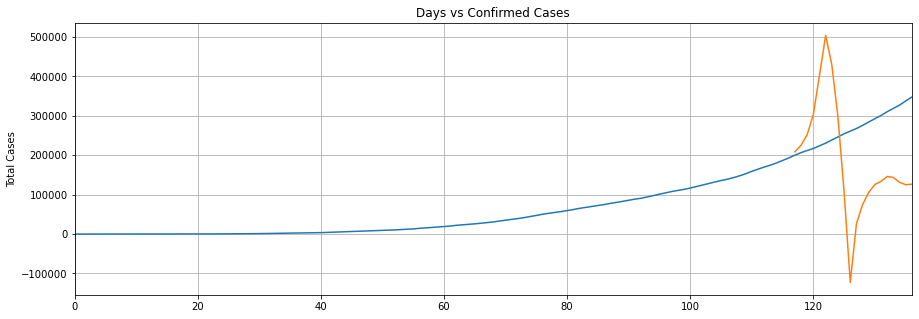

In [198]:
train_with_params(150,250,0.00025) #DO NOT TAKE

LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.75089407
epoch:  26 loss: 0.00000175
epoch:  51 loss: 0.00005745
epoch:  76 loss: 0.00021121
epoch: 101 loss: 0.00038991
epoch: 126 loss: 0.00041210
epoch: 151 loss: 0.00041232
epoch: 176 loss: 0.00039150
epoch: 201 loss: 0.00036873
epoch: 226 loss: 0.00032699
epoch: 249 loss: 0.0002851167
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


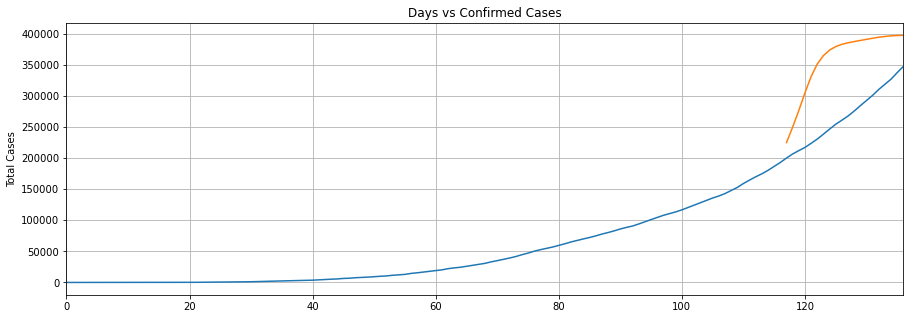

In [199]:
train_with_params(150,250,0.000125)

LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.98829162
epoch:  26 loss: 0.58203459
epoch:  51 loss: 0.08486270
epoch:  76 loss: 0.00922636
epoch: 101 loss: 0.00498906
epoch: 126 loss: 0.00378858
epoch: 151 loss: 0.00272830
epoch: 176 loss: 0.00183120
epoch: 201 loss: 0.00110077
epoch: 226 loss: 0.00054719
epoch: 249 loss: 0.0002063435
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


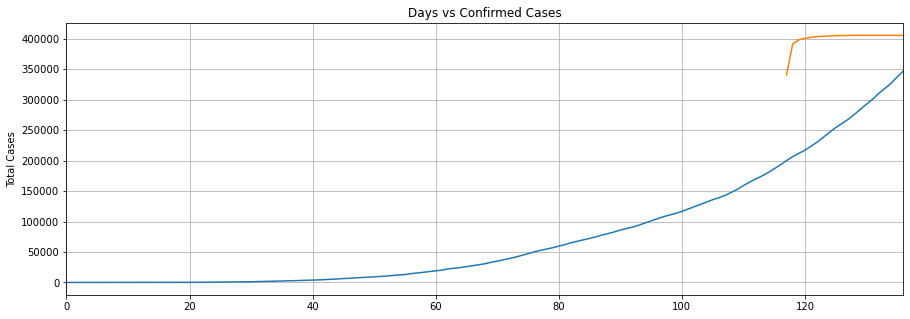

In [262]:
train_with_params(150,250,0.00001)

LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.90053582
epoch:  26 loss: 0.98162669
epoch:  51 loss: 0.55048895
epoch:  76 loss: 0.24665144
epoch: 101 loss: 0.09790205
epoch: 126 loss: 0.02634090
epoch: 151 loss: 0.01152355
epoch: 176 loss: 0.00898219
epoch: 201 loss: 0.00791912
epoch: 226 loss: 0.00708394
epoch: 249 loss: 0.0063702296
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


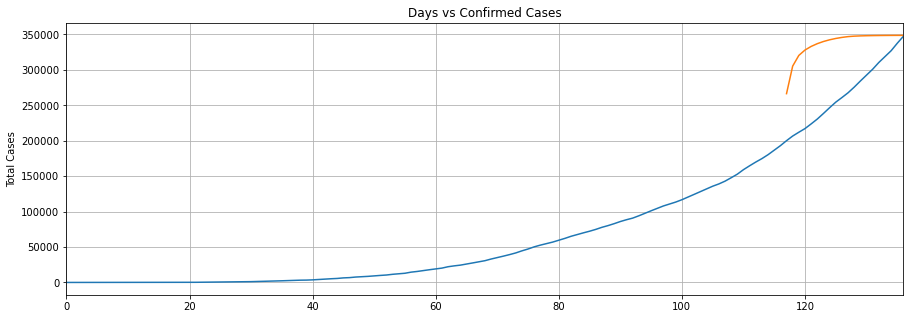

In [263]:
train_with_params(150,250,0.000005)

LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.00768800
epoch:  26 loss: 0.00009147
epoch:  51 loss: 0.00084743
epoch:  76 loss: 0.00011082
epoch: 101 loss: 0.00004620
epoch: 126 loss: 0.00014520
epoch: 151 loss: 0.00000049
epoch: 176 loss: 0.00000007
epoch: 201 loss: 0.00000007
epoch: 226 loss: 0.00000760
epoch: 249 loss: 0.0000156798
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


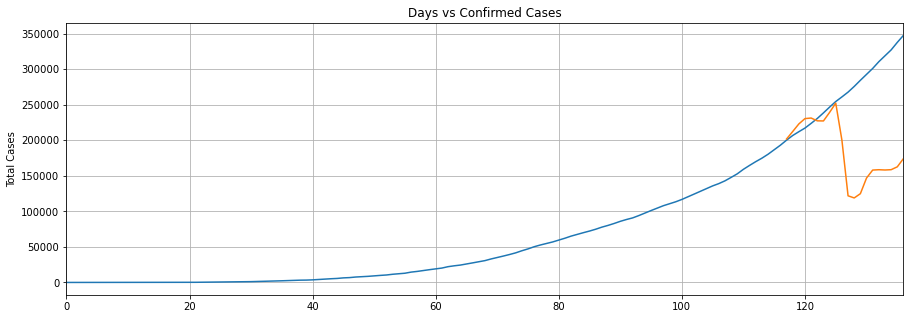

In [264]:
train_with_params(150,250,0.001)

### Setting size to 131

LSTM(
  (lstm): LSTM(1, 131)
  (linear): Linear(in_features=131, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.10770349
epoch:  26 loss: 0.00000185
epoch:  51 loss: 0.00064737
epoch:  76 loss: 0.00003291
epoch: 101 loss: 0.00009719
epoch: 126 loss: 0.00004313
epoch: 151 loss: 0.00001327
epoch: 176 loss: 0.00000684
epoch: 201 loss: 0.00000024
epoch: 226 loss: 0.00001744
epoch: 249 loss: 0.0000291497
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


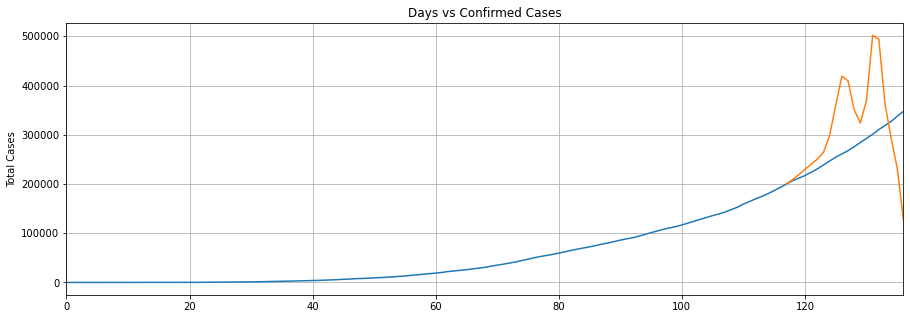

In [265]:
train_with_params(131,250,0.001)

LSTM(
  (lstm): LSTM(1, 131)
  (linear): Linear(in_features=131, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.90226412
epoch:  26 loss: 0.64659375
epoch:  51 loss: 0.14542703
epoch:  76 loss: 0.01697124
epoch: 101 loss: 0.00662283
epoch: 126 loss: 0.00496677
epoch: 151 loss: 0.00360828
epoch: 176 loss: 0.00245390
epoch: 201 loss: 0.00150429
epoch: 226 loss: 0.00077074
epoch: 249 loss: 0.0003044954
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


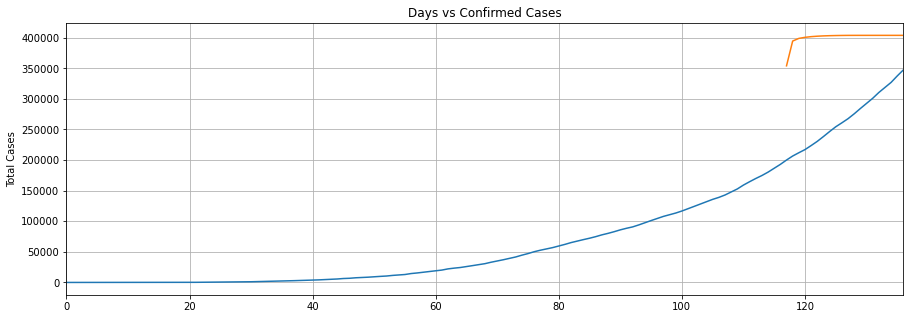

In [200]:
train_with_params(131,250,0.00001)

LSTM(
  (lstm): LSTM(1, 131)
  (linear): Linear(in_features=131, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.89725029
epoch:  26 loss: 0.00015674
epoch:  51 loss: 0.00007397
epoch:  76 loss: 0.00000351
epoch: 101 loss: 0.00022237
epoch: 126 loss: 0.00039679
epoch: 151 loss: 0.00042963
epoch: 176 loss: 0.00042287
epoch: 201 loss: 0.00037134
epoch: 226 loss: 0.00026500
epoch: 249 loss: 0.0001264369
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


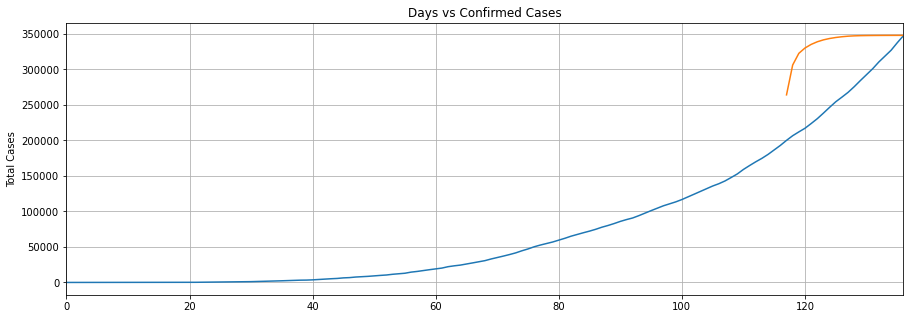

In [267]:
train_with_params(131,250,0.0001)

LSTM(
  (lstm): LSTM(1, 131)
  (linear): Linear(in_features=131, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.05804980
epoch:  26 loss: 0.00180140
epoch:  51 loss: 0.00034506
epoch:  76 loss: 0.00000283
epoch: 101 loss: 0.00019856
epoch: 126 loss: 0.00033295
epoch: 151 loss: 0.00032861
epoch: 176 loss: 0.00030169
epoch: 201 loss: 0.00026999
epoch: 226 loss: 0.00023114
epoch: 249 loss: 0.0001904802
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


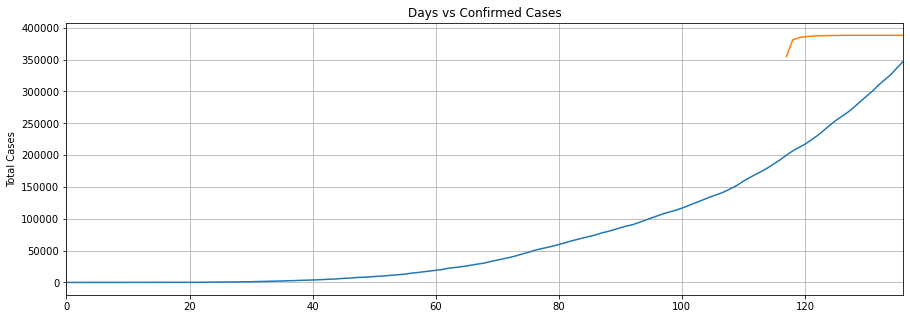

In [268]:
train_with_params(131,250,0.00005)

LSTM(
  (lstm): LSTM(1, 131)
  (linear): Linear(in_features=131, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.00290036
epoch:  26 loss: 0.00027130
epoch:  51 loss: 0.00000900
epoch:  76 loss: 0.00049529
epoch: 101 loss: 0.00066192
epoch: 126 loss: 0.00063340
epoch: 151 loss: 0.00061938
epoch: 176 loss: 0.00058263
epoch: 201 loss: 0.00054715
epoch: 226 loss: 0.00045563
epoch: 249 loss: 0.0003806180
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


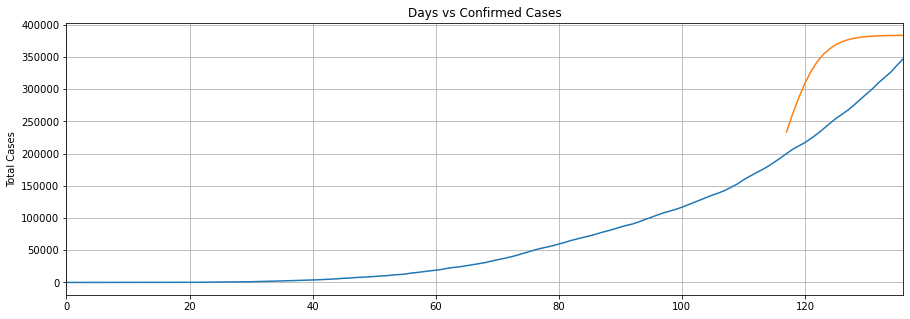

In [201]:
train_with_params(131,250,0.000125)

LSTM(
  (lstm): LSTM(1, 131)
  (linear): Linear(in_features=131, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.00333059
epoch:  26 loss: 0.00107213
epoch:  51 loss: 0.00006417
epoch:  76 loss: 0.00006632
epoch: 101 loss: 0.00006639
epoch: 126 loss: 0.00006640
epoch: 151 loss: 0.00006640
epoch: 176 loss: 0.00006640
epoch: 201 loss: 0.00006640
epoch: 226 loss: 0.00006640
epoch: 249 loss: 0.0000663969
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


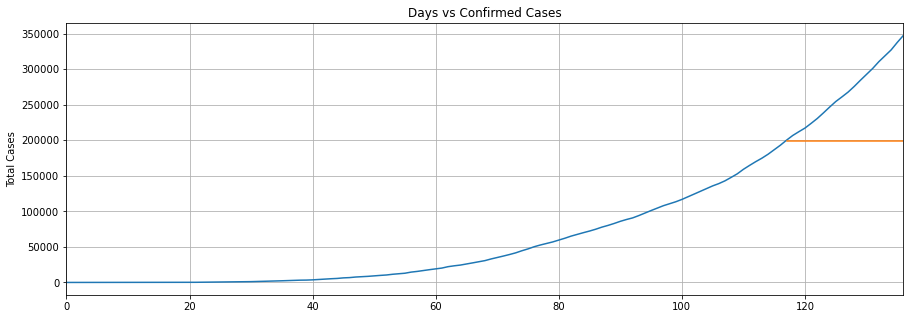

In [202]:
train_with_params(131,250,0.25)

LSTM(
  (lstm): LSTM(1, 131)
  (linear): Linear(in_features=131, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.09026933
epoch:  26 loss: 0.00066229
epoch:  51 loss: 0.00000006
epoch:  76 loss: 0.00050238
epoch: 101 loss: 0.00060172
epoch: 126 loss: 0.00058694
epoch: 151 loss: 0.00059040
epoch: 176 loss: 0.00058402
epoch: 201 loss: 0.00055161
epoch: 226 loss: 0.00051768
epoch: 249 loss: 0.0004676682
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


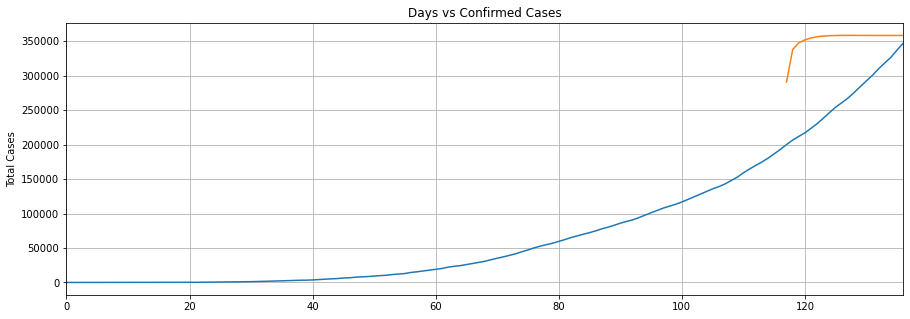

In [271]:
train_with_params(131,250,0.0001)

LSTM(
  (lstm): LSTM(1, 131)
  (linear): Linear(in_features=131, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.03997803
epoch:  26 loss: 0.00189000
epoch:  51 loss: 0.00023479
epoch:  76 loss: 0.00001069
epoch: 101 loss: 0.00026516
epoch: 126 loss: 0.00033135
epoch: 151 loss: 0.00031458
epoch: 176 loss: 0.00029456
epoch: 201 loss: 0.00027101
epoch: 226 loss: 0.00024363
epoch: 249 loss: 0.0002157938
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


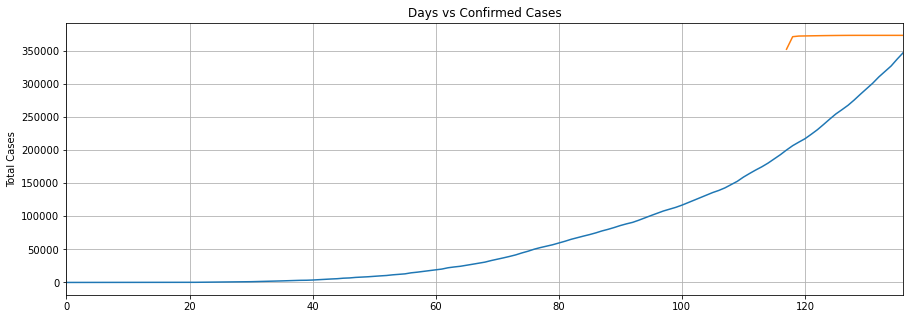

In [205]:
train_with_params(131,250,0.00005)

## Going to 100

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.04466226
epoch:  26 loss: 0.00000149
epoch:  51 loss: 0.00075134
epoch:  76 loss: 0.00021444
epoch: 101 loss: 0.00001311
epoch: 126 loss: 0.00038943
epoch: 151 loss: 0.00003523
epoch: 176 loss: 0.00000185
epoch: 201 loss: 0.00003585
epoch: 226 loss: 0.00001405
epoch: 249 loss: 0.0000105617
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


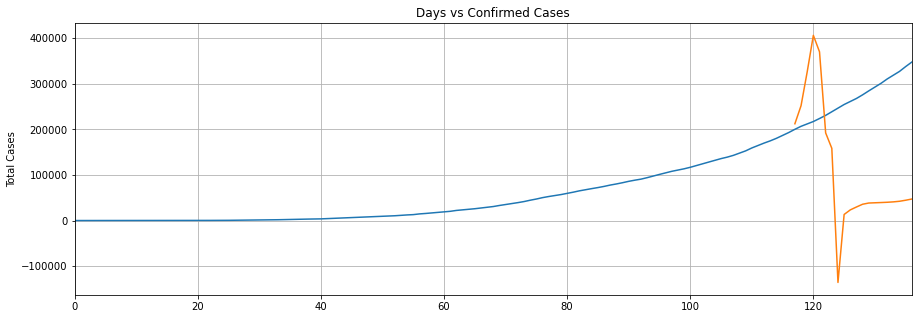

In [206]:
train_with_params(100,250,0.001)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.13013288
epoch:  26 loss: 0.00000715
epoch:  51 loss: 0.00035470
epoch:  76 loss: 0.00007053
epoch: 101 loss: 0.00002190
epoch: 126 loss: 0.00002597
epoch: 151 loss: 0.00004886
epoch: 176 loss: 0.00014809
epoch: 201 loss: 0.00004163
epoch: 226 loss: 0.00023827
epoch: 249 loss: 0.0000158227
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


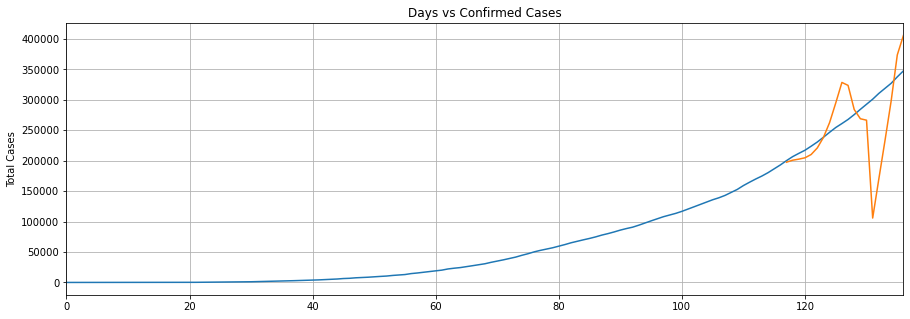

In [208]:
train_with_params(100,250,0.0005)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.83860540
epoch:  26 loss: 0.74782676
epoch:  51 loss: 0.33194834
epoch:  76 loss: 0.09174239
epoch: 101 loss: 0.01900045
epoch: 126 loss: 0.01139372
epoch: 151 loss: 0.00876649
epoch: 176 loss: 0.00668280
epoch: 201 loss: 0.00487610
epoch: 226 loss: 0.00332548
epoch: 249 loss: 0.0021321694
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


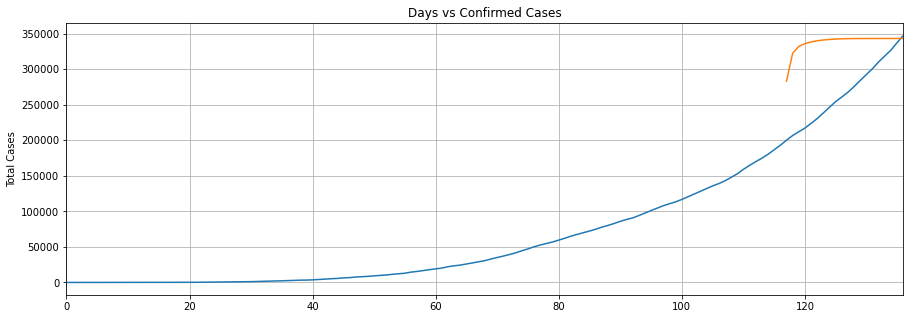

In [209]:
train_with_params(100,250,0.00001)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.93129283
epoch:  26 loss: 0.19064441
epoch:  51 loss: 0.00715758
epoch:  76 loss: 0.00284054
epoch: 101 loss: 0.00126711
epoch: 126 loss: 0.00038712
epoch: 151 loss: 0.00003966
epoch: 176 loss: 0.00002097
epoch: 201 loss: 0.00012792
epoch: 226 loss: 0.00019234
epoch: 249 loss: 0.0002013549
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


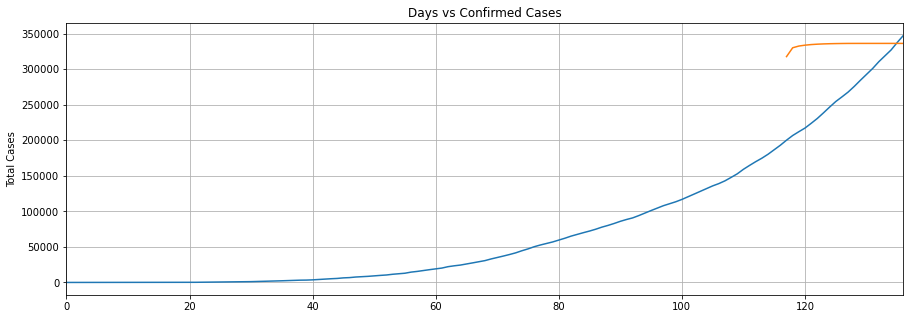

In [210]:
train_with_params(100,250,0.000025)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.89203650
epoch:  26 loss: 1.04430044
epoch:  51 loss: 0.88425678
epoch:  76 loss: 0.58739871
epoch: 101 loss: 0.36031625
epoch: 126 loss: 0.20747890
epoch: 151 loss: 0.09987099
epoch: 176 loss: 0.03947928
epoch: 201 loss: 0.02240091
epoch: 226 loss: 0.01710189
epoch: 249 loss: 0.0148683796
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


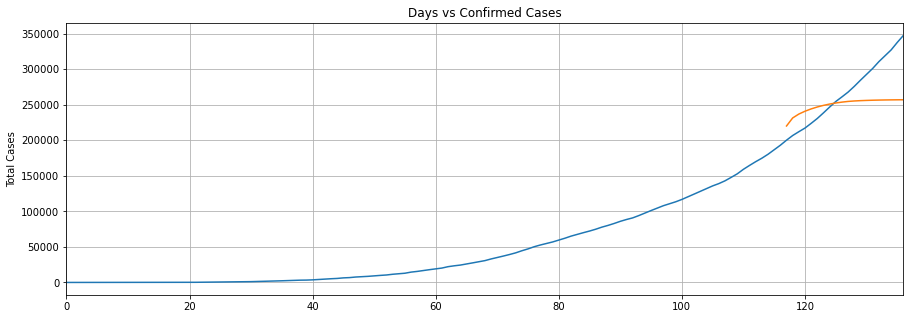

In [211]:
train_with_params(100,250,0.000005)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.09701705
epoch:  26 loss: 0.00034931
epoch:  51 loss: 0.00013617
epoch:  76 loss: 0.00058440
epoch: 101 loss: 0.00057259
epoch: 126 loss: 0.00056697
epoch: 151 loss: 0.00055308
epoch: 176 loss: 0.00049871
epoch: 201 loss: 0.00044430
epoch: 226 loss: 0.00037043
epoch: 249 loss: 0.0002885773
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


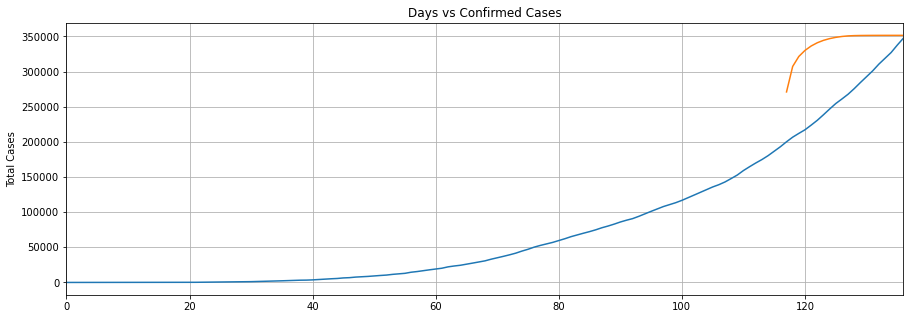

In [212]:
train_with_params(100,250,0.000125)

### Going to 75

LSTM(
  (lstm): LSTM(1, 75)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.02968301
epoch:  26 loss: 0.00062308
epoch:  51 loss: 0.00006741
epoch:  76 loss: 0.00010328
epoch: 101 loss: 0.00000159
epoch: 126 loss: 0.00000011
epoch: 151 loss: 0.00000722
epoch: 176 loss: 0.00000171
epoch: 201 loss: 0.00000274
epoch: 226 loss: 0.00001525
epoch: 251 loss: 0.00002061
epoch: 276 loss: 0.00000000
epoch: 301 loss: 0.00000773
epoch: 326 loss: 0.00001205
epoch: 351 loss: 0.00000042
epoch: 376 loss: 0.00000244
epoch: 401 loss: 0.00000808
epoch: 426 loss: 0.00000008
epoch: 451 loss: 0.00000318
epoch: 476 loss: 0.00000525
epoch: 501 loss: 0.00000688
epoch: 526 loss: 0.00000876
epoch: 551 loss: 0.00000358
epoch: 576 loss: 0.00003016
epoch: 599 loss: 0.0000000006
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.93404

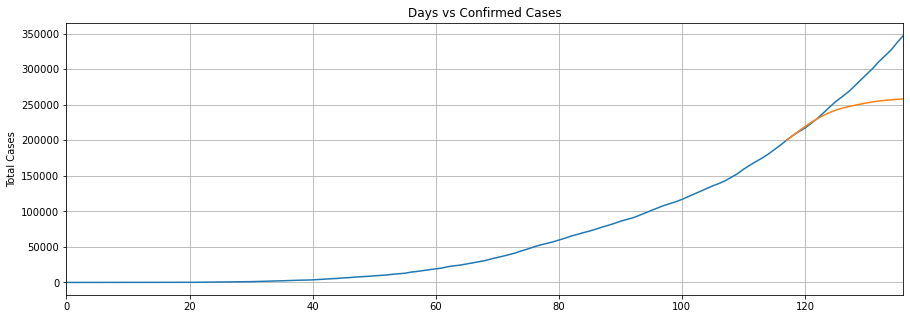

In [220]:
train_with_params(75,600,0.001)

LSTM(
  (lstm): LSTM(1, 75)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.09412968
epoch:  26 loss: 1.08983481
epoch:  51 loss: 0.57215285
epoch:  76 loss: 0.19828787
epoch: 101 loss: 0.04686602
epoch: 126 loss: 0.01829222
epoch: 151 loss: 0.01348755
epoch: 176 loss: 0.01108818
epoch: 201 loss: 0.00915373
epoch: 226 loss: 0.00746022
epoch: 249 loss: 0.0060736011
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


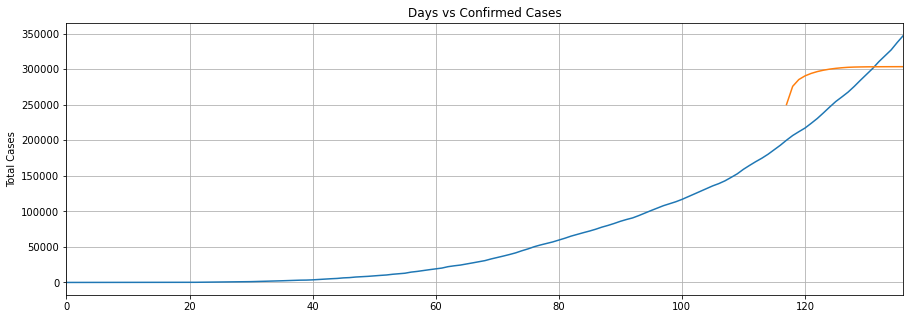

In [214]:
train_with_params(75,250,0.00001)

LSTM(
  (lstm): LSTM(1, 75)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.94319665
epoch:  26 loss: 0.01589580
epoch:  51 loss: 0.00271322
epoch:  76 loss: 0.00077878
epoch: 101 loss: 0.00005135
epoch: 126 loss: 0.00009496
epoch: 151 loss: 0.00021190
epoch: 176 loss: 0.00018368
epoch: 201 loss: 0.00013714
epoch: 226 loss: 0.00009606
epoch: 251 loss: 0.00006107
epoch: 276 loss: 0.00003426
epoch: 301 loss: 0.00001672
epoch: 326 loss: 0.00000719
epoch: 351 loss: 0.00000292
epoch: 376 loss: 0.00000127
epoch: 401 loss: 0.00000067
epoch: 426 loss: 0.00000042
epoch: 451 loss: 0.00000029
epoch: 476 loss: 0.00000021
epoch: 499 loss: 0.0000001516
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]
getting predictions...........
Got predictions, plotting: 


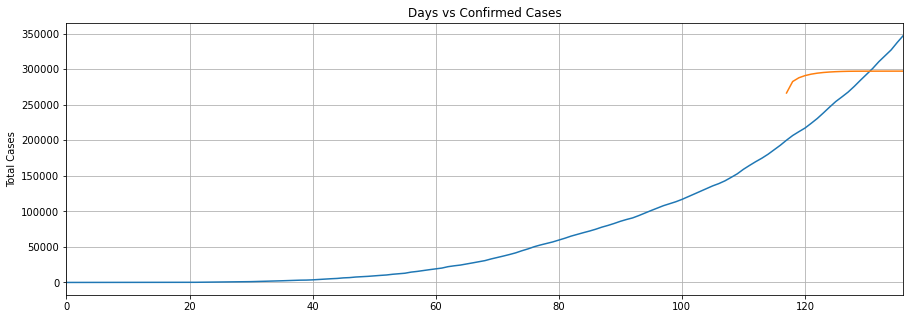

In [219]:
train_with_params(75,500,0.00005)

LSTM(
  (lstm): LSTM(1, 75)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.89021683
epoch:  26 loss: 0.00000373
epoch:  51 loss: 0.00104450
epoch:  76 loss: 0.00099206
epoch: 101 loss: 0.00071011
epoch: 126 loss: 0.00037901
epoch: 151 loss: 0.00010048
epoch: 176 loss: 0.00010923
epoch: 201 loss: 0.00000185
epoch: 226 loss: 0.00007850
epoch: 251 loss: 0.00000418
epoch: 276 loss: 0.00001271
epoch: 301 loss: 0.00003623
epoch: 326 loss: 0.00000013
epoch: 351 loss: 0.00005623
epoch: 376 loss: 0.00001037
epoch: 401 loss: 0.00007608
epoch: 426 loss: 0.00001237
epoch: 451 loss: 0.00008211
epoch: 476 loss: 0.00003011
epoch: 501 loss: 0.00007765
epoch: 526 loss: 0.00002717
epoch: 551 loss: 0.00007171
epoch: 576 loss: 0.00003601
epoch: 601 loss: 0.00003648
epoch: 626 loss: 0.00008462
epoch: 651 loss: 0.00002965
epoch: 676 loss: 0.00008174
epoch: 699 loss: 0.0000175438
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824

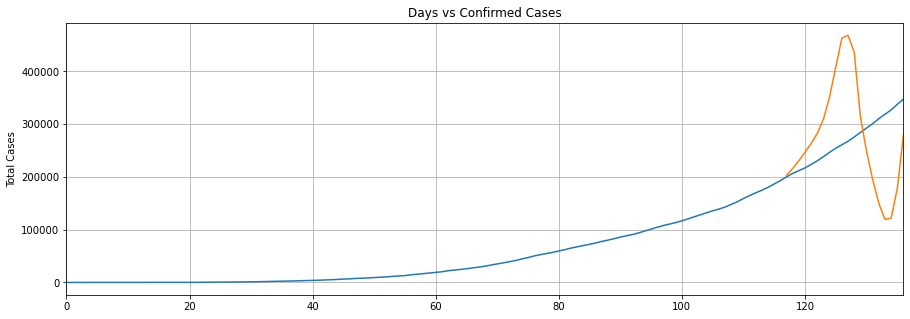

In [218]:
train_with_params(75,700,0.00025)

### 50

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.94476521
epoch:  26 loss: 0.00142463
epoch:  51 loss: 0.00001123
epoch:  76 loss: 0.00040109
epoch: 101 loss: 0.00024427
epoch: 126 loss: 0.00008376
epoch: 151 loss: 0.00000003
epoch: 176 loss: 0.00001880
epoch: 201 loss: 0.00001222
epoch: 226 loss: 0.00001202
epoch: 251 loss: 0.00001032
epoch: 276 loss: 0.00000943
epoch: 301 loss: 0.00000934
epoch: 326 loss: 0.00001097
epoch: 351 loss: 0.00001205
epoch: 376 loss: 0.00001218
epoch: 401 loss: 0.00000810
epoch: 426 loss: 0.00000035
epoch: 451 loss: 0.00001012
epoch: 476 loss: 0.00007338
epoch: 501 loss: 0.00003478
epoch: 526 loss: 0.00001452
epoch: 551 loss: 0.00004276
epoch: 576 loss: 0.00004361
epoch: 601 loss: 0.00000376
epoch: 626 loss: 0.00000809
epoch: 651 loss: 0.00004418
epoch: 676 loss: 0.00005419
epoch: 699 loss: 0.0000090919
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824

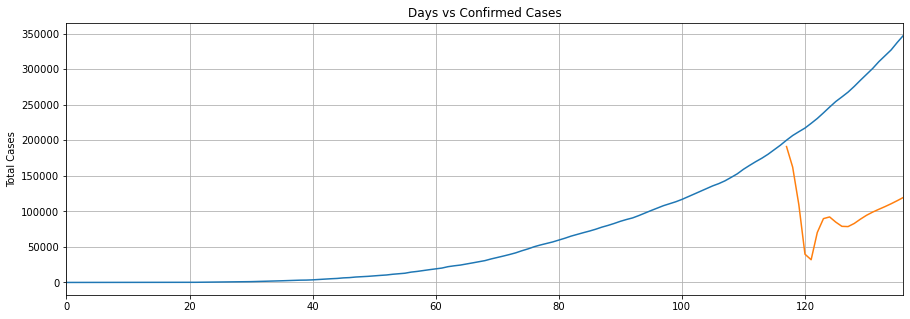

In [221]:
train_with_params(50,700,0.00025)

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.81760168
epoch:  26 loss: 0.82105637
epoch:  51 loss: 0.42092180
epoch:  76 loss: 0.19051690
epoch: 101 loss: 0.06401577
epoch: 126 loss: 0.02764328
epoch: 151 loss: 0.01909449
epoch: 176 loss: 0.01528552
epoch: 201 loss: 0.01259480
epoch: 226 loss: 0.01034294
epoch: 251 loss: 0.00837440
epoch: 276 loss: 0.00663715
epoch: 301 loss: 0.00510591
epoch: 326 loss: 0.00376576
epoch: 351 loss: 0.00261143
epoch: 376 loss: 0.00164835
epoch: 401 loss: 0.00089241
epoch: 426 loss: 0.00036483
epoch: 451 loss: 0.00007640
epoch: 476 loss: 0.00000003
epoch: 501 loss: 0.00003749
epoch: 526 loss: 0.00008456
epoch: 551 loss: 0.00011237
epoch: 576 loss: 0.00012441
epoch: 601 loss: 0.00012720
epoch: 626 loss: 0.00012502
epoch: 651 loss: 0.00012028
epoch: 676 loss: 0.00011428
epoch: 701 loss: 0.00010776
epoch: 726 loss: 0.00010110
epoch: 751 loss: 0.00009453
epoch: 776 loss: 0.000088

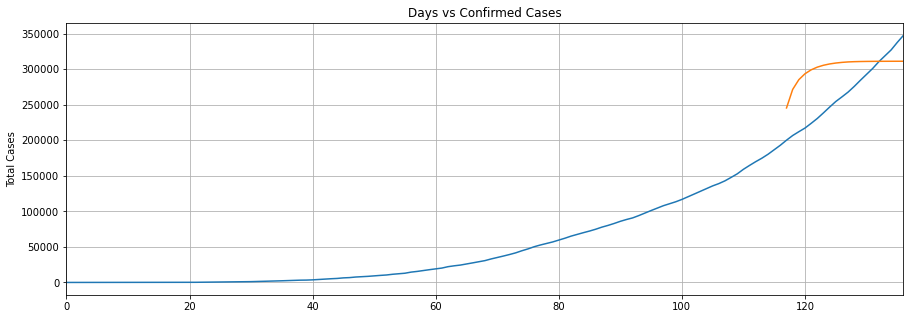

In [225]:
train_with_params(50,900,0.0000125)

LSTM(
  (lstm): LSTM(1, 75)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.08935789
epoch:  26 loss: 0.00004929
epoch:  51 loss: 0.00028801
epoch:  76 loss: 0.00002892
epoch: 101 loss: 0.00014313
epoch: 126 loss: 0.00000571
epoch: 151 loss: 0.00004588
epoch: 176 loss: 0.00003153
epoch: 201 loss: 0.00002590
epoch: 226 loss: 0.00004164
epoch: 251 loss: 0.00000855
epoch: 276 loss: 0.00000202
epoch: 301 loss: 0.00005610
epoch: 326 loss: 0.00000030
epoch: 351 loss: 0.00003569
epoch: 376 loss: 0.00002708
epoch: 401 loss: 0.00000762
epoch: 426 loss: 0.00002544
epoch: 451 loss: 0.00000269
epoch: 476 loss: 0.00018996
epoch: 501 loss: 0.00001158
epoch: 526 loss: 0.00000063
epoch: 551 loss: 0.00000081
epoch: 576 loss: 0.00000597
epoch: 599 loss: 0.0000001043
Now testing...........
[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.93404

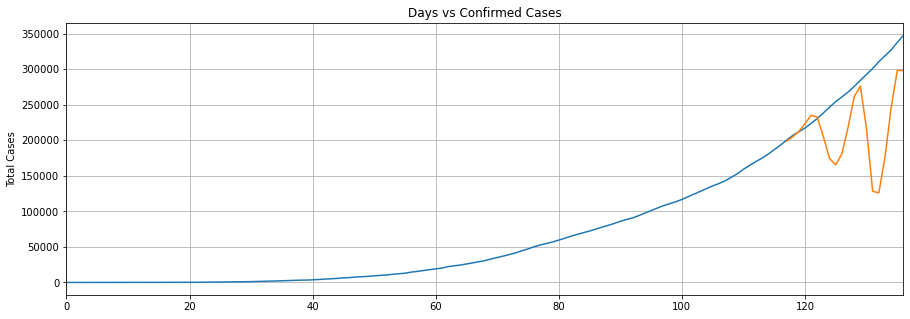

In [228]:
train_with_params(75,600,0.00075)

LSTM(
  (lstm): LSTM(1, 75)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.50112629
epoch:  26 loss: 0.00007711
epoch:  51 loss: 0.00023503
epoch:  76 loss: 0.00000414
epoch: 101 loss: 0.00004197
epoch: 126 loss: 0.00001720
epoch: 151 loss: 0.00039026
epoch: 176 loss: 0.00010093
epoch: 201 loss: 0.00001369
epoch: 226 loss: 0.00004038
epoch: 251 loss: 0.00004677
epoch: 276 loss: 0.00001897
epoch: 301 loss: 0.00000077
epoch: 326 loss: 0.00000000
epoch: 351 loss: 0.00002593
epoch: 376 loss: 0.00000532
epoch: 401 loss: 0.00001129
epoch: 426 loss: 0.00000010
epoch: 451 loss: 0.00000055
epoch: 476 loss: 0.00001389
epoch: 501 loss: 0.00000185
epoch: 526 loss: 0.00011645
epoch: 551 loss: 0.00000283
epoch: 576 loss: 0.00000469
epoch: 599 loss: 0.0000000433
Now testing...........
[0.28845247626304626, 0.32860067486763, 0.36870741844177246, 0.40726998448371887, 0.44057828187942505, 0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.649

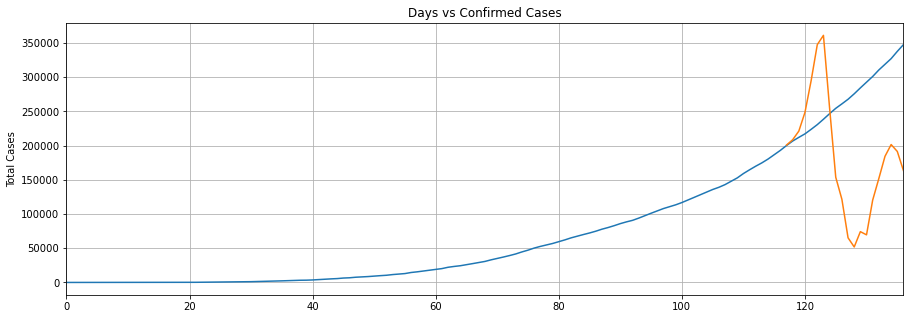

In [236]:
train_with_params(75,600,0.00065)

LSTM(
  (lstm): LSTM(1, 75)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.66894269
epoch:  26 loss: 0.00009194
epoch:  51 loss: 0.00009962
epoch:  76 loss: 0.00000637
epoch: 101 loss: 0.00003806
epoch: 126 loss: 0.00005019
epoch: 151 loss: 0.00003185
epoch: 176 loss: 0.00000679
epoch: 201 loss: 0.00000087
epoch: 226 loss: 0.00000076
epoch: 251 loss: 0.00000649
epoch: 276 loss: 0.00000368
epoch: 301 loss: 0.00002400
epoch: 326 loss: 0.00000009
epoch: 351 loss: 0.00000279
epoch: 376 loss: 0.00001016
epoch: 401 loss: 0.00000011
epoch: 426 loss: 0.00000008
epoch: 451 loss: 0.00000040
epoch: 476 loss: 0.00000073
epoch: 501 loss: 0.00000125
epoch: 526 loss: 0.00000115
epoch: 551 loss: 0.00022795
epoch: 576 loss: 0.00000252
epoch: 599 loss: 0.0000277252
Now testing...........
[0.28845247626304626, 0.32860067486763, 0.36870741844177246, 0.40726998448371887, 0.44057828187942505, 0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.649

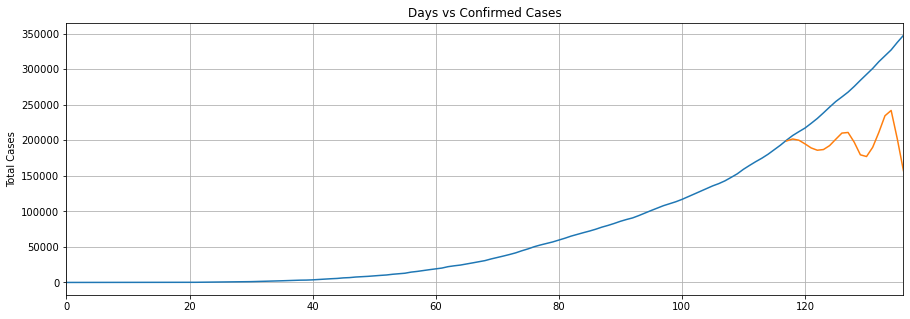

In [237]:
train_with_params(75,600,0.00070)

LSTM(
  (lstm): LSTM(1, 75)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.10807050
epoch:  26 loss: 0.00001266
epoch:  51 loss: 0.00005494
epoch:  76 loss: 0.00000579
epoch: 101 loss: 0.00000423
epoch: 126 loss: 0.00000530
epoch: 151 loss: 0.00000018
epoch: 176 loss: 0.00002017
epoch: 201 loss: 0.00007325
epoch: 226 loss: 0.00002197
epoch: 251 loss: 0.00005436
epoch: 276 loss: 0.00003777
epoch: 301 loss: 0.00000842
epoch: 326 loss: 0.00000677
epoch: 351 loss: 0.00000087
epoch: 376 loss: 0.00000692
epoch: 401 loss: 0.00000076
epoch: 426 loss: 0.00000961
epoch: 451 loss: 0.00001352
epoch: 476 loss: 0.00000095
epoch: 501 loss: 0.00004959
epoch: 526 loss: 0.00009170
epoch: 551 loss: 0.00002037
epoch: 576 loss: 0.00000115
epoch: 599 loss: 0.0004761466
Now testing...........
[0.28845247626304626, 0.32860067486763, 0.36870741844177246, 0.40726998448371887, 0.44057828187942505, 0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.649

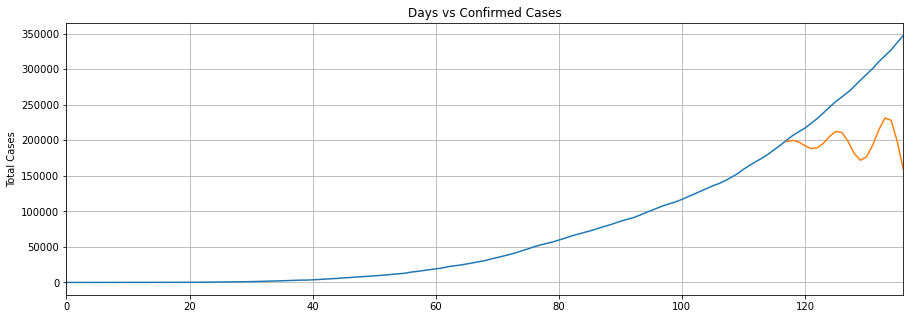

In [238]:
train_with_params(75,600,0.00068)

# Trying with d= d.diff()

In [254]:
d1=d.diff()

In [255]:
d1.dropna(inplace = True)

In [256]:
d1

,Confirmed
Date,
2020-03-12,6.0
2020-03-13,3.0
2020-03-15,18.0
2020-03-17,7.0
2020-03-18,3.0
...,...
2020-07-20,9518.0
2020-07-21,8240.0
2020-07-22,8336.0


In [257]:
all_data = d1['Confirmed'].values.astype(float)

In [258]:
print(all_data)

[6.0000e+00 3.0000e+00 1.8000e+01 7.0000e+00 3.0000e+00 5.0000e+00
 5.0000e+00 1.1000e+01 4.0000e+00 7.0000e+00 1.5000e+01 3.9000e+01
 2.0000e+00 5.0000e+01 6.0000e+00 1.2000e+01 1.8000e+01 8.6000e+01
 3.3000e+01 1.5500e+02 2.5800e+02 1.2000e+02 1.5000e+02 1.1700e+02
 2.2900e+02 2.1000e+02 1.8700e+02 2.2400e+02 3.5200e+02 3.5000e+02
 2.3200e+02 2.8600e+02 1.1800e+02 3.2800e+02 5.5200e+02 4.6600e+02
 5.5200e+02 4.3100e+02 7.7800e+02 3.8700e+02 8.1100e+02 4.4000e+02
 5.2200e+02 7.2800e+02 5.9700e+02 5.8300e+02 1.0080e+03 7.9000e+02
 6.7800e+02 1.5670e+03 9.8400e+02 1.2330e+03 1.2160e+03 1.0890e+03
 1.1650e+03 1.9430e+03 1.2300e+03 1.0260e+03 1.4950e+03 1.6020e+03
 1.5760e+03 1.6060e+03 2.3470e+03 2.0050e+03 2.0780e+03 2.1610e+03
 2.3450e+03 2.9400e+03 2.6080e+03 3.0410e+03 2.4360e+03 2.0910e+03
 2.1900e+03 2.5980e+03 2.6820e+03 2.9400e+03 2.4870e+03 2.3580e+03
 2.2870e+03 2.5600e+03 2.9330e+03 2.4360e+03 2.7390e+03 3.0070e+03
 2.5530e+03 2.2590e+03 3.2540e+03 3.6070e+03 3.4930e+03 3.4270

In [259]:
test_data_size = 20

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [260]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [261]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.99874332]
 [-0.99968583]
 [-0.9949733 ]
 [-0.99842915]
 [-0.99968583]]
[[0.65095822]
 [0.53188816]
 [0.73892554]
 [0.98743324]
 [0.99874332]]


In [262]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [263]:
train_window = 15

In [264]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [265]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [266]:
train_inout_seq[:5]

[(tensor([-0.9987, -0.9997, -0.9950, -0.9984, -0.9997, -0.9991, -0.9991, -0.9972,
          -0.9994, -0.9984, -0.9959, -0.9884, -1.0000, -0.9849, -0.9987]),
  tensor([-0.9969])),
 (tensor([-0.9997, -0.9950, -0.9984, -0.9997, -0.9991, -0.9991, -0.9972, -0.9994,
          -0.9984, -0.9959, -0.9884, -1.0000, -0.9849, -0.9987, -0.9969]),
  tensor([-0.9950])),
 (tensor([-0.9950, -0.9984, -0.9997, -0.9991, -0.9991, -0.9972, -0.9994, -0.9984,
          -0.9959, -0.9884, -1.0000, -0.9849, -0.9987, -0.9969, -0.9950]),
  tensor([-0.9736])),
 (tensor([-0.9984, -0.9997, -0.9991, -0.9991, -0.9972, -0.9994, -0.9984, -0.9959,
          -0.9884, -1.0000, -0.9849, -0.9987, -0.9969, -0.9950, -0.9736]),
  tensor([-0.9903])),
 (tensor([-0.9997, -0.9991, -0.9991, -0.9972, -0.9994, -0.9984, -0.9959, -0.9884,
          -1.0000, -0.9849, -0.9987, -0.9969, -0.9950, -0.9736, -0.9903]),
  tensor([-0.9519]))]

In [267]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.02446926
epoch:  26 loss: 0.00731784
epoch:  51 loss: 0.00595782
epoch:  76 loss: 0.00551703
epoch: 101 loss: 0.00521378
epoch: 126 loss: 0.00283477
epoch: 151 loss: 0.00006291
epoch: 176 loss: 0.00001412
epoch: 201 loss: 0.00040838
epoch: 226 loss: 0.00120388
epoch: 249 loss: 0.0019126588
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


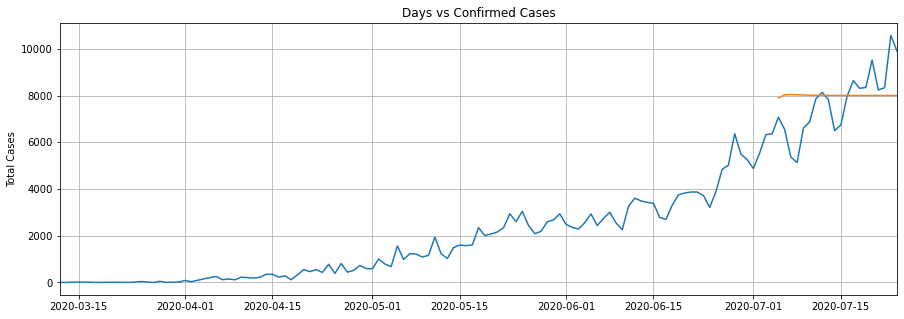

In [197]:
train_with_params(100,250,0.0001)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.19801855
epoch:  26 loss: 0.00003102
epoch:  51 loss: 0.00321429
epoch:  76 loss: 0.00536536
epoch: 101 loss: 0.00700175
epoch: 126 loss: 0.00793201
epoch: 151 loss: 0.00804442
epoch: 176 loss: 0.00704681
epoch: 201 loss: 0.00432092
epoch: 226 loss: 0.00077828
epoch: 249 loss: 0.0000055971
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


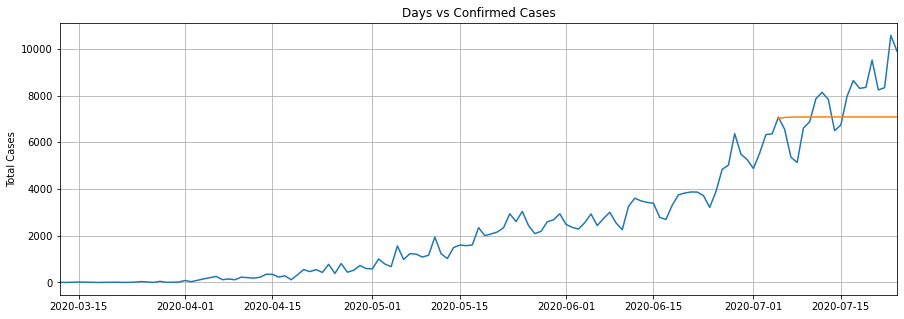

In [198]:
train_with_params(100,250,0.00005)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.14772820
epoch:  26 loss: 0.45526886
epoch:  51 loss: 0.01528378
epoch:  76 loss: 0.00059683
epoch: 101 loss: 0.00238356
epoch: 126 loss: 0.00429831
epoch: 151 loss: 0.00603853
epoch: 176 loss: 0.00733710
epoch: 201 loss: 0.00798892
epoch: 226 loss: 0.00782217
epoch: 249 loss: 0.0068323538
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


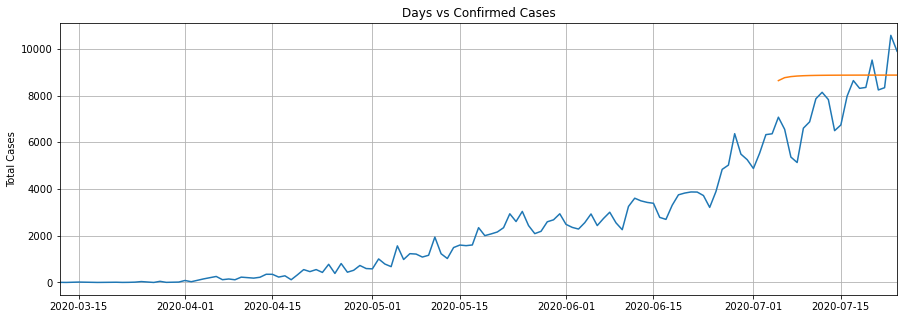

In [199]:
train_with_params(100,250,0.000025)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.96645433
epoch:  26 loss: 0.00791124
epoch:  51 loss: 0.00476375
epoch:  76 loss: 0.00345919
epoch: 101 loss: 0.00133075
epoch: 126 loss: 0.00008228
epoch: 151 loss: 0.00030233
epoch: 176 loss: 0.00471454
epoch: 201 loss: 0.01209720
epoch: 226 loss: 0.00285988
epoch: 249 loss: 0.0000071840
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


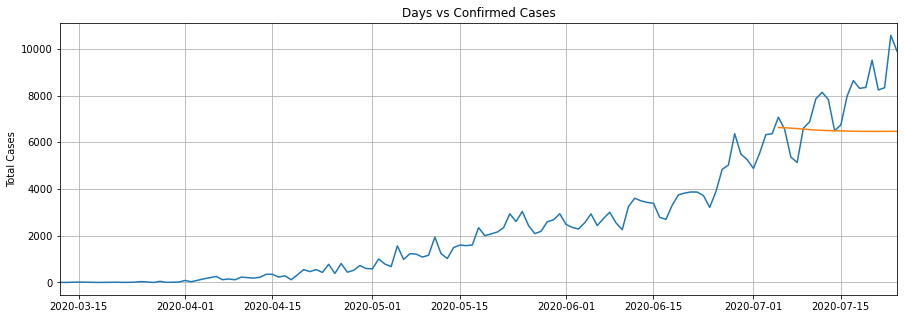

In [200]:
train_with_params(100,250,0.000125)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.01011150
epoch:  26 loss: 0.01696648
epoch:  51 loss: 0.05692240
epoch:  76 loss: 0.00234232
epoch: 101 loss: 0.00335195
epoch: 126 loss: 0.00079013
epoch: 151 loss: 0.00021713
epoch: 176 loss: 0.00225955
epoch: 201 loss: 0.00319328
epoch: 226 loss: 0.00031003
epoch: 249 loss: 0.0033706441
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


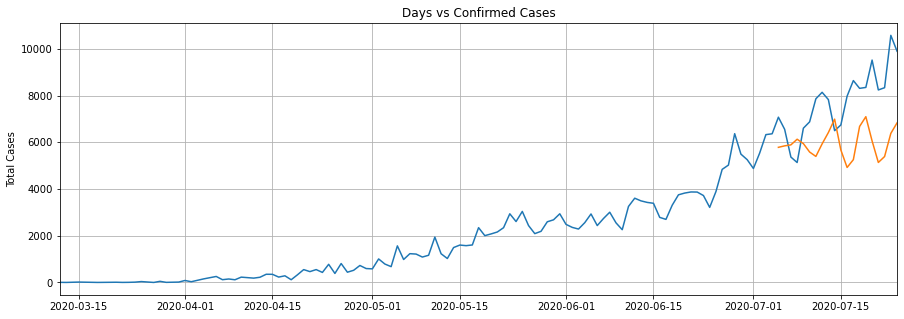

In [201]:
train_with_params(100,250,0.001)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.02125649
epoch:  26 loss: 0.00256128
epoch:  51 loss: 0.00582786
epoch:  76 loss: 0.00578756
epoch: 101 loss: 0.00019263
epoch: 126 loss: 0.00001713
epoch: 151 loss: 0.00161646
epoch: 176 loss: 0.00012088
epoch: 201 loss: 0.00024346
epoch: 226 loss: 0.00064365
epoch: 249 loss: 0.0004589059
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


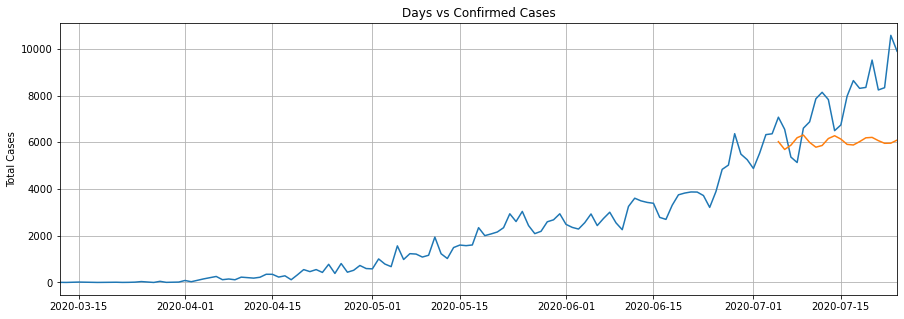

In [202]:
train_with_params(100,250,0.0025)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 1.01780570
epoch:  26 loss: 0.01649338
epoch:  51 loss: 0.00835329
epoch:  76 loss: 0.00572963
epoch: 101 loss: 0.01094060
epoch: 126 loss: 0.00789861
epoch: 151 loss: 0.00427593
epoch: 176 loss: 0.00813430
epoch: 201 loss: 0.03948864
epoch: 226 loss: 0.00470163
epoch: 251 loss: 0.01248199
epoch: 276 loss: 0.00133138
epoch: 301 loss: 0.00649045
epoch: 326 loss: 0.00051890
epoch: 351 loss: 0.00368913
epoch: 376 loss: 0.00044839
epoch: 401 loss: 0.00173533
epoch: 426 loss: 0.00019370
epoch: 451 loss: 0.00235600
epoch: 476 loss: 0.00023651
epoch: 499 loss: 0.0030247450
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432

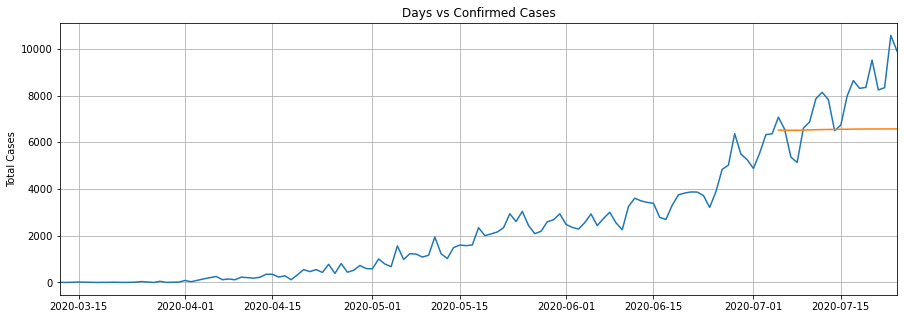

In [206]:
train_with_params(200,500,0.0001)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.37745765
epoch:  26 loss: 0.00951789
epoch:  51 loss: 0.00056616
epoch:  76 loss: 0.01075212
epoch: 101 loss: 0.01156257
epoch: 126 loss: 0.00147174
epoch: 151 loss: 0.00695582
epoch: 176 loss: 0.00037332
epoch: 201 loss: 0.00002838
epoch: 226 loss: 0.00038617
epoch: 249 loss: 0.0024190682
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


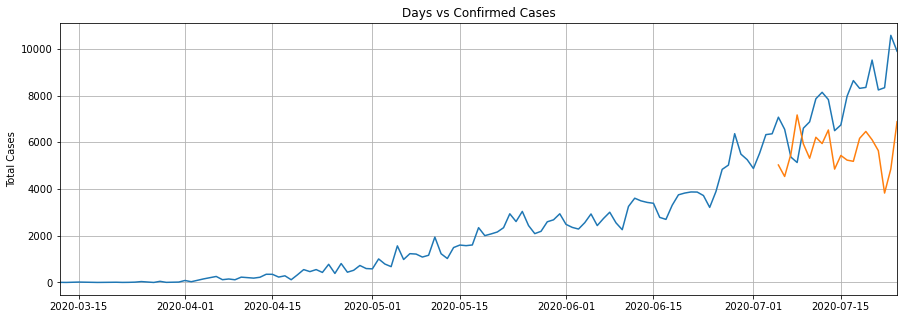

In [204]:
train_with_params(200,250,0.0005)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.35560098
epoch:  26 loss: 0.00000052
epoch:  51 loss: 0.01880245
epoch:  76 loss: 0.00017923
epoch: 101 loss: 0.00282237
epoch: 126 loss: 0.00034685
epoch: 151 loss: 0.00047348
epoch: 176 loss: 0.00112869
epoch: 201 loss: 0.00000010
epoch: 226 loss: 0.00000213
epoch: 249 loss: 0.0000259573
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


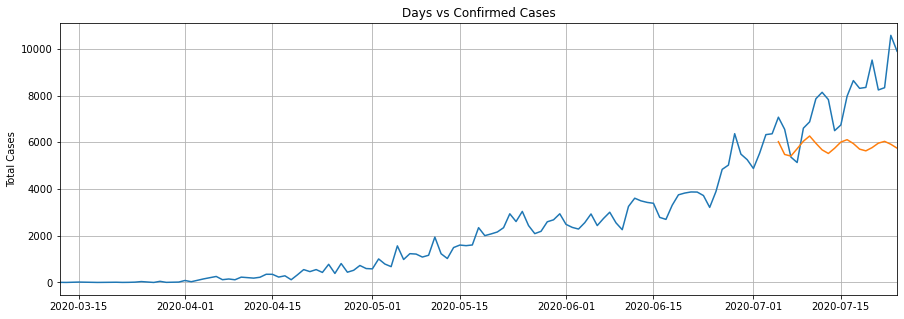

In [205]:
train_with_params(200,250,0.0025)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.74263763
epoch:  26 loss: 0.00331745
epoch:  51 loss: 0.01743082
epoch:  76 loss: 0.00876010
epoch: 101 loss: 0.00207023
epoch: 126 loss: 0.00050178
epoch: 151 loss: 0.00068087
epoch: 176 loss: 0.00131271
epoch: 201 loss: 0.00028428
epoch: 226 loss: 0.00020436
epoch: 249 loss: 0.0000903706
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


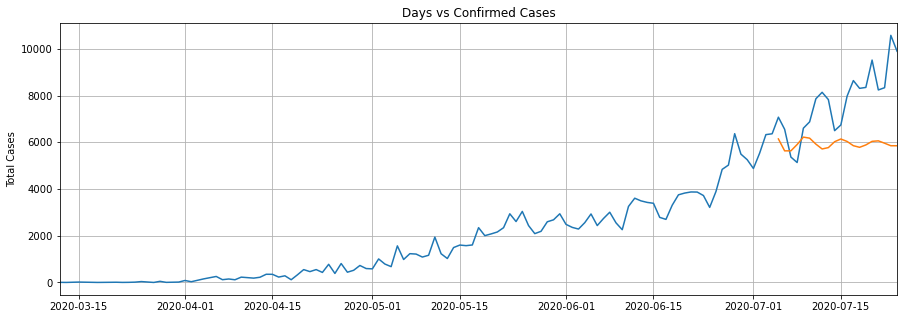

In [207]:
train_with_params(200,250,0.005)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.15490448
epoch:  26 loss: 0.00327044
epoch:  51 loss: 0.00357949
epoch:  76 loss: 0.00135830
epoch: 101 loss: 0.00056941
epoch: 126 loss: 0.00053522
epoch: 151 loss: 0.00129148
epoch: 176 loss: 0.00431167
epoch: 201 loss: 0.00010790
epoch: 226 loss: 0.00000399
epoch: 251 loss: 0.00432389
epoch: 276 loss: 0.00000666
epoch: 301 loss: 0.00281966
epoch: 326 loss: 0.00015211
epoch: 351 loss: 0.00121161
epoch: 376 loss: 0.00000170
epoch: 401 loss: 0.00003402
epoch: 426 loss: 0.00008048
epoch: 451 loss: 0.00003014
epoch: 476 loss: 0.00003539
epoch: 499 loss: 0.0000039320
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432

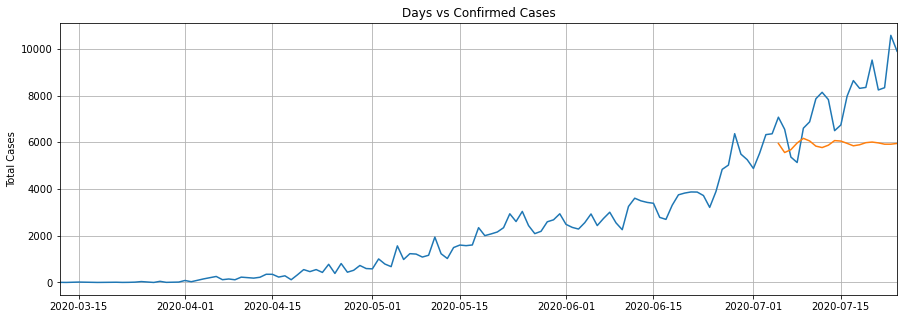

In [209]:
train_with_params(200,500,0.0025)

LSTM(
  (lstm): LSTM(1, 75)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.15365331
epoch:  26 loss: 0.00326566
epoch:  51 loss: 0.00002006
epoch:  76 loss: 0.00423637
epoch: 101 loss: 0.00021166
epoch: 126 loss: 0.00004910
epoch: 151 loss: 0.00027301
epoch: 176 loss: 0.00076311
epoch: 201 loss: 0.00234067
epoch: 226 loss: 0.00024404
epoch: 249 loss: 0.0003401746
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


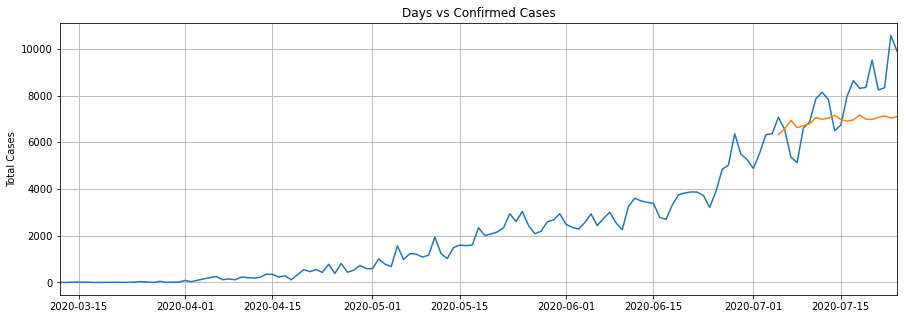

In [211]:
train_with_params(75,250,0.005)

In [282]:
def train_with_paramsv2(hl_size,n_epochs, learn_rate):
    class LSTM(nn.Module):
        def __init__(self, input_size=1, hidden_layer_size=hl_size, output_size=1):
            super().__init__()
            self.hidden_layer_size = hidden_layer_size

            self.lstm = nn.LSTM(input_size, hidden_layer_size)

            self.linear = nn.Linear(hidden_layer_size, output_size)

            self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                                torch.zeros(1,1,self.hidden_layer_size))

        def forward(self, input_seq):
            lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
            predictions = self.linear(lstm_out.view(len(input_seq), -1))
            return predictions[-1]
    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    print(model)
    epochs = n_epochs
    print('training model')
    for i in range(epochs):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    fut_pred = 20
    print("Now testing...........")
    test_inputs = train_data_normalized[-train_window:].tolist()
    print(test_inputs)
    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())
    print("getting predictions...........")
    actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
    actual_predictions[0][0] += d.iloc[-fut_pred,0] 
    for i in range(1,len(actual_predictions)):
        actual_predictions[i][0] += actual_predictions[i-1][0]
    print("Got predictions, plotting: ")
    x = d1.index[-20:]
    plt.title('Days vs Confirmed Cases')
    plt.ylabel('Total Cases')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(d['Confirmed'])
    plt.plot(x,actual_predictions)
    plt.show()

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.50736576
epoch:  26 loss: 0.00565663
epoch:  51 loss: 0.05139108
epoch:  76 loss: 0.04755064
epoch: 101 loss: 0.01261415
epoch: 126 loss: 0.00454613
epoch: 151 loss: 0.00312873
epoch: 176 loss: 0.00225265
epoch: 201 loss: 0.00157876
epoch: 226 loss: 0.00222290
epoch: 249 loss: 0.0002042034
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


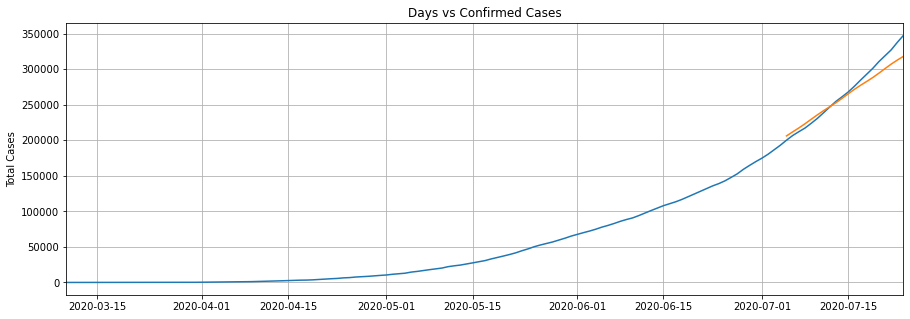

In [283]:
train_with_paramsv2(200,250,0.001)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
training model
epoch:   1 loss: 0.01022636
epoch:  26 loss: 0.00702717
epoch:  51 loss: 0.00520314
epoch:  76 loss: 0.00124671
epoch: 101 loss: 0.00356569
epoch: 126 loss: 0.00197134
epoch: 151 loss: 0.00000579
epoch: 176 loss: 0.00089538
epoch: 201 loss: 0.00012425
epoch: 226 loss: 0.00186008
epoch: 249 loss: 0.0004284694
Now testing...........
[0.201696515083313, 0.21646246314048767, 0.21520577371120453, 0.16839459538459778, 0.00911090150475502, 0.22148916125297546, 0.5202639102935791, 0.5777568221092224, 1.0, 0.7251021265983582, 0.650958240032196, 0.5318881273269653, 0.7389255166053772, 0.9874332547187805, 0.9987432956695557]
getting predictions...........
Got predictions, plotting: 


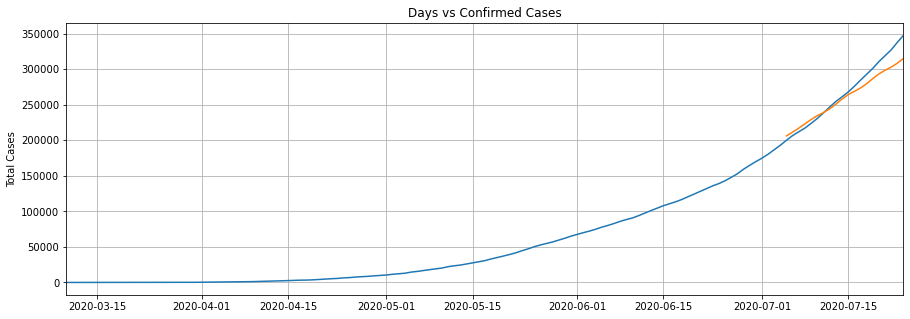

In [284]:
train_with_paramsv2(100,250,0.001)